<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports/Setup" data-toc-modified-id="Imports/Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports/Setup</a></span></li><li><span><a href="#Flatten-Versions" data-toc-modified-id="Flatten-Versions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Flatten Versions</a></span></li><li><span><a href="#Test-Assumptions" data-toc-modified-id="Test-Assumptions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test Assumptions</a></span><ul class="toc-item"><li><span><a href="#Latest-Version-=-Delta-to-Original" data-toc-modified-id="Latest-Version-=-Delta-to-Original-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Latest Version = Delta to Original</a></span></li><li><span><a href="#Only-Irrelevant-Changes-Filtered" data-toc-modified-id="Only-Irrelevant-Changes-Filtered-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Only Irrelevant Changes Filtered</a></span></li></ul></li><li><span><a href="#Stats:-Manual-Corrections-(File-Level)" data-toc-modified-id="Stats:-Manual-Corrections-(File-Level)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stats: Manual Corrections (File Level)</a></span><ul class="toc-item"><li><span><a href="#Missing-Station-Data" data-toc-modified-id="Missing-Station-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Missing Station Data</a></span><ul class="toc-item"><li><span><a href="#NSG" data-toc-modified-id="NSG-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>NSG</a></span></li><li><span><a href="#ZRP" data-toc-modified-id="ZRP-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>ZRP</a></span></li></ul></li></ul></li><li><span><a href="#Stats:-Automatic-QA" data-toc-modified-id="Stats:-Automatic-QA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stats: Automatic QA</a></span></li><li><span><a href="#Load-All-Samples-Failing-AutoQA" data-toc-modified-id="Load-All-Samples-Failing-AutoQA-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load All Samples Failing AutoQA</a></span></li><li><span><a href="#Data-Driven:-Variable-Selection" data-toc-modified-id="Data-Driven:-Variable-Selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Data Driven: Variable Selection</a></span></li><li><span><a href="#Target-variable" data-toc-modified-id="Target-variable-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Target variable</a></span></li><li><span><a href="#Stats:-Target-Variable" data-toc-modified-id="Stats:-Target-Variable-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Stats: Target Variable</a></span><ul class="toc-item"><li><span><a href="#Manuel-Correction-Overrides" data-toc-modified-id="Manuel-Correction-Overrides-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Manuel Correction Overrides</a></span></li><li><span><a href="#False-Positives" data-toc-modified-id="False-Positives-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>False Positives</a></span></li><li><span><a href="#False-Negatives" data-toc-modified-id="False-Negatives-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>False Negatives</a></span></li><li><span><a href="#Incidents" data-toc-modified-id="Incidents-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Incidents</a></span></li></ul></li><li><span><a href="#QC-Remarks" data-toc-modified-id="QC-Remarks-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>QC Remarks</a></span></li></ul></div>

# Imports/Setup

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../src/data')

In [3]:
import os
import csv
import pickle

import pandas as pd 
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from xml2dict import *
from dict2tabular import *

# Flatten Versions

Separate the values of automatic quality assement (first) and manuel correction (last versions) of the xml files:

In [4]:
def state_after_automatic_qa(df_xml):
    """ Filters dataframe to contain only versions used for autmatic quality assessment (original).
    If no dataframe is provided than first df_xml is created from extracted pickles in interim folder.
    """  
    if not isinstance(df_xml, pd.DataFrame):
        df_xml = all_extract_pickles_to_dataframe(stage='interim')
    return df_xml[df_xml.version == '0']
 
    
def state_after_manual_correction(df_xml, include_unchanged: bool = False):
    """ Filters dataframe to contain only versions created due to manual correction (most current). """
    if not include_unchanged: 
        df_xml = df_xml[df_xml.version != '0']
    return df_xml.sort_values(by=['station_time_identifier', 'version']
                             ).drop_duplicates(subset=['station_time_identifier'], keep='last')

In [5]:
def filter_versions_without_relevant_changes(df, relevant_cols: list = None):
    """ Filters out irrelevant changes (e.g. only system created) by filtering columns by a set of buzzwords to be
    contained and then dropping rows who have no extracted values in all these fields."""
    if not relevant_cols:
        # The values orig-value and value_override are included in the value check
        relevant_cols = ['value',  'overall_qa_summary', 'qa_flag_override']

    cols_interest = [col for col in df.columns if any(word in col for word in relevant_cols)]
    df_interest = df[cols_interest]
    df_interest = df_interest.dropna(how="all").copy()
    print('--- Out of %d files with corrections only %d have relevant changes.---' %(len(df), len(df_interest)))
    return df.loc[df.index.isin(df_interest.index)]

In [6]:
def flatten_versions(df):
    """ Reduce the different versions of the xml into single row with first and last state information. 
    
    Params:
        df (pd.DataFrame) - DataFrame with xml information.
        
    Returns:
        df_flat (pd.DataFrame) - DataFrame with all versions summarized into one row
    
    """
    df_orig = state_after_automatic_qa(df_xml=df)
    df_recent = state_after_manual_correction(df_xml=df)
    df_recent = filter_versions_without_relevant_changes(df=df_recent)
    df_recent = df_recent.add_suffix("_post_mc")

    df_flat = df_orig.merge(df_recent, 
                            how='left', 
                            left_on="station_time_identifier", 
                            right_on="station_time_identifier_post_mc",
                            indicator=True)
    return df_flat

In [7]:
def pickle_to_flat_df(file_path: str, only_changed: bool =True):
    df = extract_pickle_to_dataframe(file_path=file_path)
    df_flat = flatten_versions(df)
    if only_changed:
        df_flat = df_flat[df_flat._merge!='left_only']
    return df_flat

In [8]:
def complete_flat_df(stage='interim', only_changed=False):
    folder = main_folder(stage=stage)
    num_cpu = multiprocessing.cpu_count()-1
    df_iterable = Parallel(n_jobs=num_cpu)(delayed(pickle_to_flat_df
                                                  )(file_path=file, only_changed=only_changed) 
                                           for file in folder)
    df_result = pd.concat(df_iterable)
    return df_result

# Test Assumptions

## Latest Version = Delta to Original

Part of the implicit assumption so far when dropping prior versions of the xml's is that no information will be lost in this way as the changes are not logged incrementally only from version to version but always as cumulative difference to the original. 

This assumption should be examined:

In [9]:
def test_incremental_change_assumption():
    """If not incremental, then for all changes also the latest version must have changed. 
    
    If something is printed than the assumption is disproven. 
    The other way around its only and indicator that fulling the assumption. 
    
    Remark: Assuming the assumption is true than this is also a good sanity check for state_after_manual_correction.
    """
    main_list = main_folder(stage='interim')
    for pickle_file in main_list:
        df = extract_pickle_to_dataframe(pickle_file)   
        df_final = state_after_manual_correction(df_xml=df)
        df_changes = df[df.version != '0']
        for station_time_identifier in df_changes.station_time_identifier.unique() :
            assert station_time_identifier in df_final.station_time_identifier.unique(), "For %s the change is not in the last version but in a prior." % station_time_identifier

    print("All tests passed.")

test_incremental_change_assumption()  

All tests passed.


## Only Irrelevant Changes Filtered

Verify that the versions we filtered out are not based on a bug in our extraction script:

In [10]:
def df_categorization(df, print_out: bool=True):
    """ In order to to easily get the stats for different categories this functions builds different versions of the 
    dataframe containing different subsets of the data. 
    
    
    Returns:
        df_all_changes (DataFrame) - Slice df containing only information related to changes (non-original) 
        df_all_changes_relevant (DataFrame) -  Slice of df containing only files which changes that are not completely empty. 
        df_recent (DataFrame) - Slice of df containing only the highest version number for each station+time combination
        df_recent_relevant (DataFrame) - Slice of df containing highest versions numbers which are not empty. 
    
    """
    if not print_out:
        block_print()
    
    df_all_changes = df[df.version!='0'].copy()
    print("Station %s : From all files which are not original:"% df.tc_identifier.unique()[0])
    df_all_changes_relevant = filter_versions_without_relevant_changes(df=df_all_changes)
    df_recent = state_after_manual_correction(df_xml=df)
    print("Station %s : From all files which are the most recent and not the original:"% df.tc_identifier.unique()[0])
    df_recent_relevant = filter_versions_without_relevant_changes(df=df_recent)
    
    enable_print()
    
    return df_all_changes, df_all_changes_relevant, df_recent, df_recent_relevant

In [11]:
def test_station_override_and_status_indicators(station_pickle_path: str, result_dict:dict):
    """ Verifies following assumptions about the connection between data and functions:
    
    1.) DataFrame row is not filtered out by `filter_versions_without_relevant_changes` 
    <=> original file does not contain the words 'override' or 'status-indicators'
    
    2.) File contains the words 'override' or 'status-indicators'
    <=> DataFrame row selected by `state_after_manual_correction` with the same station_time_identifier (unique)
    is relevant (see 1.)
    
    The 2.) gives another indicator that changes are relative to the original version 
    because the values 'override' and 'status_indicators' seem to be handed on to the next version
    """
    df = extract_pickle_to_dataframe(file_path=station_pickle_path)
    df_all_changes, df_all_changes_relevant, df_recent, df_recent_relevant = df_categorization(df)
    
    # Indicator for comparision in loop
    df_all_changes['most_recent'] = False
    df_all_changes.loc[df_recent.index, 'most_recent'] = True

    df_all_changes['relevant'] = False
    df_all_changes.loc[df_all_changes_relevant.index,'relevant'] = True

    df_all_changes['last_is_relevant'] = False
    df_all_changes.loc[df_all_changes.station_time_identifier.isin(df_recent_relevant.station_time_identifier), 'last_is_relevant'] = True

    for df_index in df_all_changes.index: 
        origin_file_row=df_all_changes.loc[df_index]
        # Ensure the row is unique
        assert origin_file_row.shape == (len(origin_file_row),)
        # Load file for direct comparision
        xml_soup = xml2soup(origin_file_row.origin_filename.replace('../../','../'))
        xml_soup_str = str(xml_soup)
        if origin_file_row.relevant==True:
            assert origin_file_row.last_is_relevant==True, "Incremental assumption fails for %s"%origin_file
            assert ('override') in xml_soup_str, "Relevant file %s does not contain the string 'override'."%origin_file
            assert ('status-indicators') in xml_soup_str, "Relevant file %s does not contain the string 'status-indicators'."%origin_file
        elif origin_file_row.relevant==False:
            assert ('override') not in xml_soup_str, "Irrelevant file %s does contain the string override."%origin_file
            assert ('status-indicators') not in xml_soup_str, "Irrelevant file %s does contain the string 'status-indicators'."%origin_file

            
def test_override_and_status_indicators(path: str = '../data/interim/eccc_ml_qa/all_stations_2019/deploy/', multi_process=True):
    folder = [path+file for file in os.listdir(path) if '.pickle' in file] 
    result_dict = {}
    if multi_process: 
        Parallel(n_jobs=multiprocessing.cpu_count()-1)(delayed(test_station_override_and_status_indicators
                                                            )(station_pickle_path=station,
                                                              result_dict=result_dict)
                                                     for station in folder)
        
    if not multi_process:     
        for station in folder:
            test_station_override_and_status_indicators(station=station, result_dict=result_dict)      
    print("All stations passed the tests.")
    

In [12]:
%%time
test_override_and_status_indicators()

All stations passed the tests.
Wall time: 33min 37s


The test indicates that the chosen criteria to only extract values for measurements which have elements containing the words 'override' or 'status-indicators' is suitable and this has been confirmed via mail by Syed Haider (02.03.2020 03:20 PM), that there should be no changes where these indicators are not present. 

# Stats: Manual Corrections (File Level)

In [13]:
def station_files_categorization_counts(station_pickle_path):
    df = extract_pickle_to_dataframe(file_path=station_pickle_path)
    _, _, df_recent, df_recent_relevant = df_categorization(df)

    # Stats
    result_dict= {df.tc_identifier.unique()[0]:{}} 
    result_dict[df.tc_identifier.unique()[0]]['files'] = len(df)
    result_dict[df.tc_identifier.unique()[0]]['originals'] = len(df[df.version=='0'])
    result_dict[df.tc_identifier.unique()[0]]['last_versions'] = len(df_recent)
    result_dict[df.tc_identifier.unique()[0]]['last_version_with_changes'] = len(df_recent_relevant)    
    return result_dict

def categorization_stats(file_path: str = '../data/interim/eccc_ml_qa/all_stations_2019/deploy/', multi_process=True):
    folder = [file_path+file for file in os.listdir(file_path) if '.pickle' in file] 
    result_dict = {}
    if multi_process:
        dict_iterable = Parallel(n_jobs=multiprocessing.cpu_count()-1)(delayed(station_files_categorization_counts
                                                                             )(station_pickle_path=station)
                                                                     for station in folder)
        for chunk_result in dict_iterable:
            result_dict.update(chunk_result)  
    
    elif not multi_process:
        for station in folder: 
            chunk_result = station_files_categorization_counts(station_pickle_path=station)
            result_dict.update(chunk_result)
        
    return result_dict 

In [14]:
stats_dict_all_stations = categorization_stats()
save_pickle(folder_path='../data/processed/', file_name='stats_dict_all_stations_test', save_object=stats_dict_all_stations)

In [15]:
stats_dict_all_stations = read_pickle(file='../data/processed/stats_dict_all_stations_test.pickle' )
df_file_stats = pd.DataFrame(stats_dict_all_stations).T

<ipython-input-16-c441b7c78cb0>:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


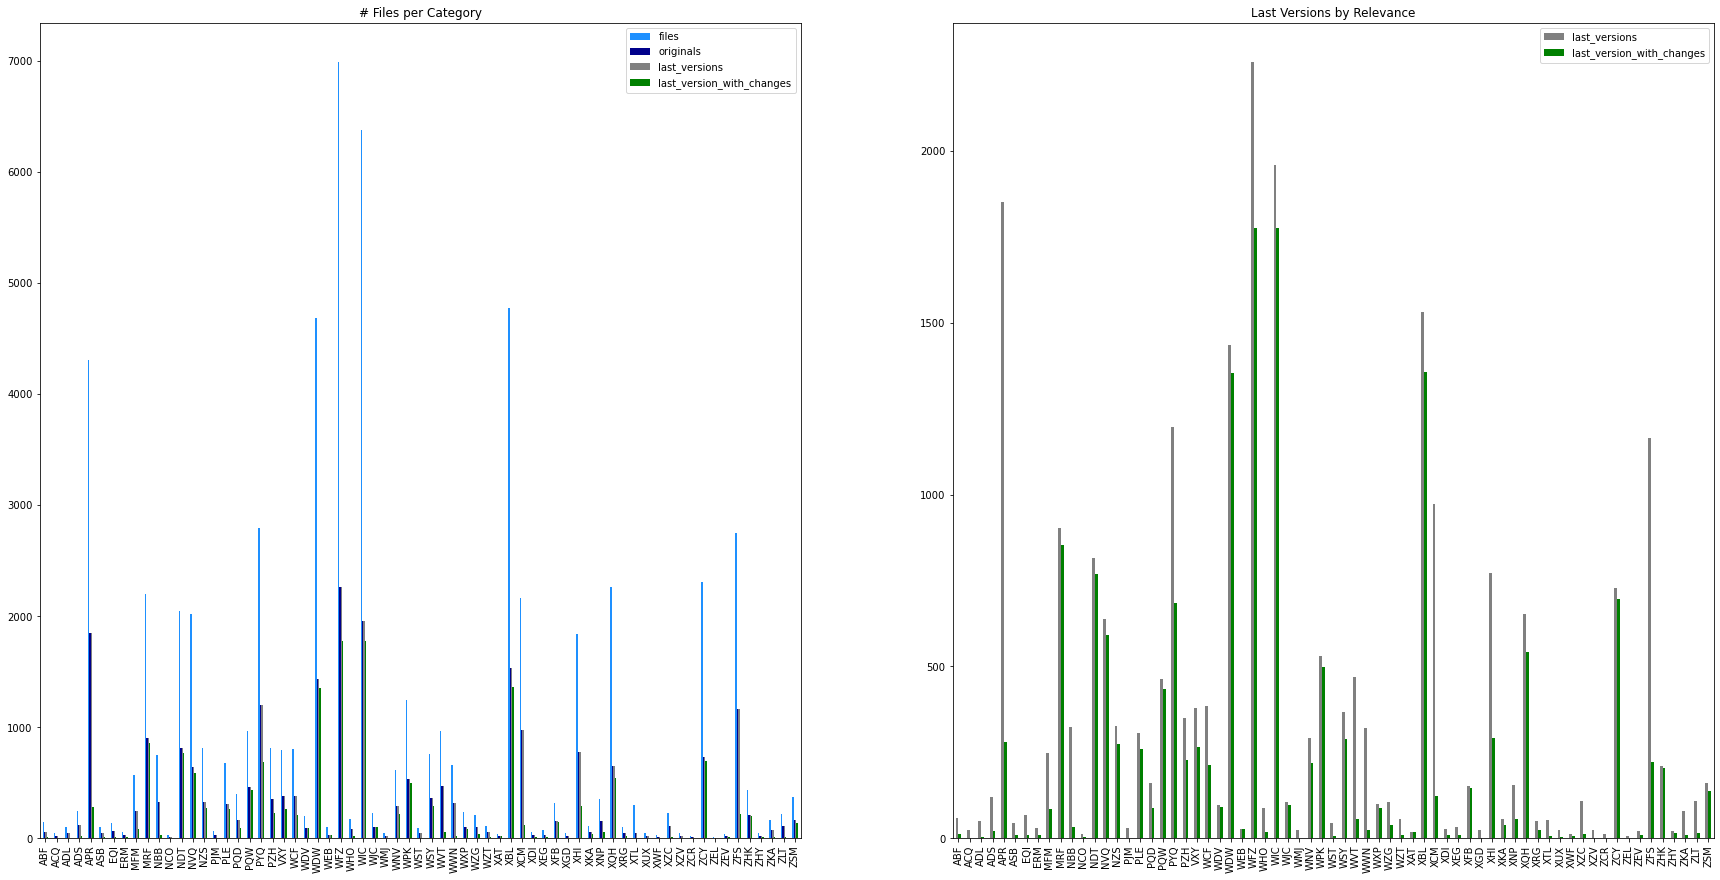

In [16]:


fig = plt.figure(figsize=(30,15))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_file_stats.plot.bar(ax=ax1, color=['dodgerblue', 'darkblue', 'gray','green'], title='# Files per Category')
df_file_stats[['last_versions', 'last_version_with_changes']].plot.bar(ax=ax2, color=['gray','green'], title='Last Versions by Relevance')

fig.show()

In [28]:
print(df_file_stats)

     files  originals  last_versions  last_version_with_changes
ABF    147         58             58                         12
ACQ     51         25             25                          2
ADL    105         51             51                          5
ADS    244        119            119                         20
APR   4310       1853           1853                        279
..     ...        ...            ...                        ...
ZHK    433        211            211                        205
ZHY     44         22             22                         16
ZKA    164         79             79                         10
ZLT    217        108            108                         14
ZSM    368        161            161                        138

[67 rows x 4 columns]


<ipython-input-26-f30ccf3d2eef>:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


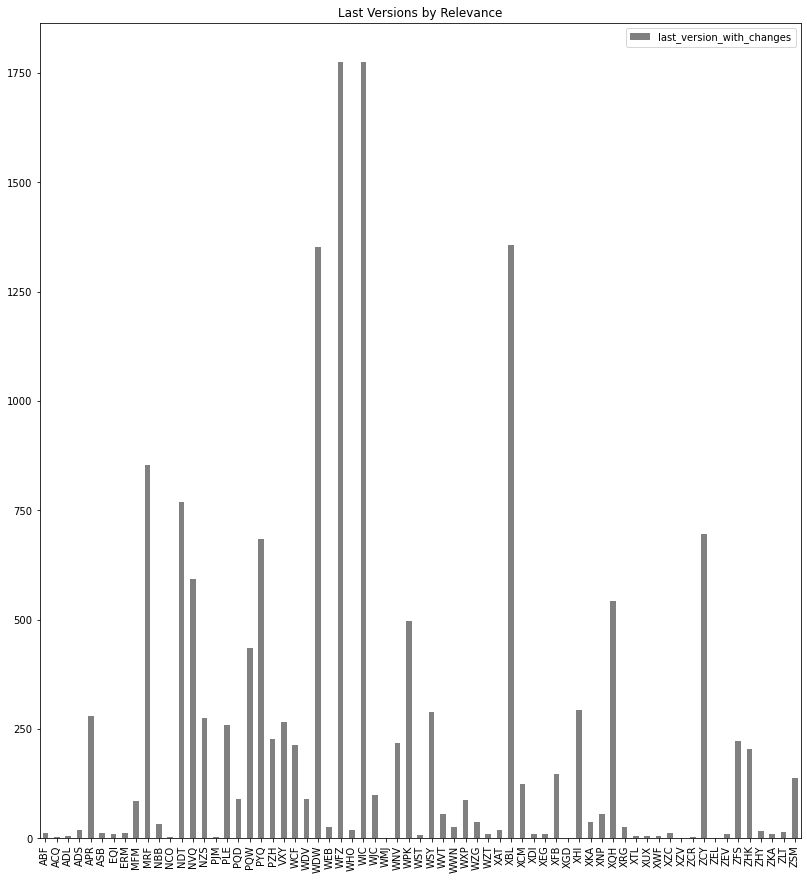

In [26]:


fig = plt.figure(figsize=(30,15))

ax1 = fig.add_subplot(121)

df_file_stats[[ 'last_version_with_changes']].plot.bar(ax=ax1, color=['gray','green'], title='Last Versions by Relevance')

fig.show()

Relative percentages of changes which are relevant:

<AxesSubplot:title={'center':'Percentage of Versions Containing Changes'}>

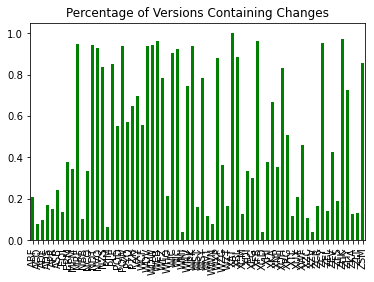

In [17]:
(df_file_stats.last_version_with_changes/df_file_stats.last_versions).plot.bar(color='g', title='Percentage of Versions Containing Changes')

This means that the number of available positive examples is reduced by 60-100% (depending on the station) which makes it an even more unbalanced classification task. Especially, that positive examples so far is referring only to xml's and not individual variables where the number of changes will be even lower. 

Percentages of original files which are changed in any way by station:

In [18]:
(df_file_stats.last_version_with_changes/df_file_stats.originals).sort_values(ascending=False)

XAT    1.000000
ZHK    0.971564
WEB    0.962963
XFB    0.960526
ZCY    0.953361
         ...   
WWN    0.077640
PJM    0.064516
XGD    0.041667
WMJ    0.041667
XZV    0.041667
Length: 67, dtype: float64

Total number of actual changes over 13 stations and 365 days:

In [19]:
df_file_stats.last_version_with_changes.sum()

15466

## Missing Station Data

The stations NSG and ZRP only have half the amount of files. First thing to validate is if only a certain timeframe was provided.

In [20]:
def get_timeframe(station_pickle_path):
    df = extract_pickle_to_dataframe(file_path=station_pickle_path)
    print("First included timestamp:", pd.to_datetime(df['date_time']).min())
    print("Last included timestamp:",pd.to_datetime(df['date_time']).max())

### wic

In [21]:
wic_path = '../data/interim/eccc_ml_qa/all_stations_2019/deploy/wic_2402604.pickle'
get_timeframe(station_pickle_path=wic_path)

First included timestamp: 2021-01-01 00:00:00+00:00
Last included timestamp: 2021-10-22 06:00:00+00:00


For the station nsg the files only start in June so it makes sense that there are roughly half the number.

### ZRP

In [22]:
wst_path = '../data/interim/eccc_ml_qa/all_stations_2019/deploy/wst_7054096.pickle'
get_timeframe(station_pickle_path=wst_path)

First included timestamp: 2021-08-17 05:00:00+00:00
Last included timestamp: 2021-08-21 06:00:00+00:00


Its not as obviously just from the start and end date. 

Distribution over months:

<AxesSubplot:title={'center':'ZRP: Files per Month'}, xlabel='date_time'>

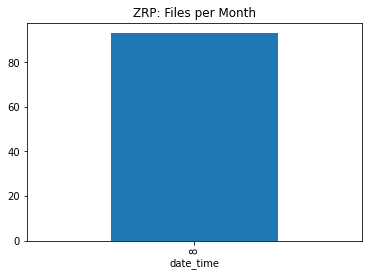

In [23]:
zrp_path = '../data/interim/eccc_ml_qa/all_stations_2019/deploy/wst_7054096.pickle'
df = extract_pickle_to_dataframe(file_path=zrp_path)
df["date_time"] = pd.to_datetime(df['date_time']) 
df.reset_index(inplace=True)
df = df[['index','date_time']]
df.groupby(df["date_time"].dt.month)['date_time'].count().plot(kind="bar", title='ZRP: Files per Month')

Seems like a similar pattern just with additional datapoints in january. 

# Stats: Automatic QA

In [29]:
df_complete_qa = state_after_automatic_qa(df_xml=None)
save_pickle(folder_path='../data/processed/', file_name='complete_auto_qa_results', save_object=df_complete_qa)

In [30]:
df_complete_qa = read_pickle('../data/processed/complete_auto_qa_results.pickle')
df_complete_qa.shape

(24256, 5127)

In [31]:
df_complete_qa = df_slice_by_string_in_column(df_complete_qa, substrings=['_value', 'overall_qa_summary'])

In [32]:
def category_counts(df, base_cols, substrings=["override", "_value"], station=None, poc_focus=True, identifier_str='post_mc'):
    df_test = df_slice_by_string_in_column(df, substrings=substrings, base_cols = base_cols)
    if station:
        df_test = df_test[df_test.station_time_identifier.str.startswith(station)].copy()
    if poc_focus:
        df_test = df_slice_by_string_in_column(df_test, substrings=["temperature", "pressure", "precipitation"], base_cols = base_cols)
    if identifier_str:
        df_test = df_slice_by_string_in_column(df_test, substrings=[identifier_str], base_cols = base_cols)
    return dict(df_test.count().sort_values(ascending=False))

In [33]:
base_cols = ["station_time_identifier", '_merge', 'origin_filename', 'origin_filename_post_mc']                                                                                     

tested_variables_count_overall = category_counts(df_complete_qa, 
                                                 base_cols, 
                                                 substrings=['_value',"overall_qa_summary"], 
                                                 poc_focus=False, 
                                                 identifier_str=None)

In [34]:
tested_variables_count_overall

{'precipitation_amount_287_value': 24256,
 'battery_voltage_1017_value': 24256,
 'precipitation_amount_287_overall_qa_summary': 24256,
 'relative_humidity_80_overall_qa_summary': 24256,
 'relative_humidity_80_value': 24256,
 'panel_temperature_1015_overall_qa_summary': 24256,
 'panel_temperature_1015_value': 24256,
 'battery_voltage_1017_overall_qa_summary': 24256,
 'battery_voltage_1016_overall_qa_summary': 24256,
 'relative_humidity_4_overall_qa_summary': 24256,
 'battery_voltage_1016_value': 24256,
 'data_availability_1006_overall_qa_summary': 24256,
 'data_availability_1006_value': 24256,
 'precipitation_amount_288_value': 24256,
 'precipitation_amount_288_overall_qa_summary': 24256,
 'precipitation_amount_12_value': 24256,
 'relative_humidity_4_value': 24256,
 'relative_humidity_5_value': 24256,
 'cumulative_precipitation_gauge_weight_filtered_283_value': 24256,
 'cumulative_precipitation_gauge_weight_filtered_283_overall_qa_summary': 24256,
 'precipitation_amount_286_overall_qa_s

In [35]:
save_pickle(folder_path='../data/processed/', file_name='tested_variables_count_overall', save_object=tested_variables_count_overall)

In [36]:
df_complete_qa = read_pickle('../data/processed/complete_auto_qa_results.pickle')

In [37]:
df_complete_qa = df_slice_by_string_in_column(df_complete_qa, substrings=['overall_qa_summary'])

Calculate number of times per station and variable that the QA test didnt result in '100':

In [38]:
(df_complete_qa!='100').groupby(df_complete_qa.index.str[0:3]).sum()

,deactivated_sensor_label_3026_overall_qa_summary,deactivated_sensor_label_5005_overall_qa_summary,deactivated_sensor_label_5006_overall_qa_summary,deactivated_sensor_label_5014_overall_qa_summary,deactivated_sensor_label_5015_overall_qa_summary,deactivated_sensor_label_5000_overall_qa_summary,deactivated_sensor_label_5001_overall_qa_summary,deactivated_sensor_label_5002_overall_qa_summary,deactivated_sensor_label_5003_overall_qa_summary,deactivated_sensor_label_5035_overall_qa_summary,...,deactivated_sensor_label_3017_overall_qa_summary,deactivated_sensor_label_10_overall_qa_summary,air_temperature_5001_overall_qa_summary,air_temperature_5015_overall_qa_summary,air_temperature_5003_overall_qa_summary,air_temperature_5006_overall_qa_summary,air_temperature_5005_overall_qa_summary,air_temperature_5014_overall_qa_summary,air_temperature_5000_overall_qa_summary,air_temperature_5002_overall_qa_summary
abf,0,0,0,0,0,0,0,0,0,0,...,58,58,58,58,58,58,58,58,58,58
acq,0,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
adl,0,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
ads,119,119,119,119,119,119,119,119,119,119,...,119,119,119,119,119,119,119,119,119,119
apr,0,1853,1853,1853,1853,1853,1853,1853,1853,1853,...,1853,1853,1853,1853,1853,1853,1853,1853,1853,1853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhk,0,0,0,0,0,0,0,0,0,0,...,211,211,211,211,211,211,211,211,211,211
zhy,0,0,0,0,0,0,0,0,0,0,...,22,22,22,22,22,22,22,22,22,22
zka,0,79,79,79,79,79,79,79,79,0,...,79,79,79,79,79,79,79,79,79,79
zlt,0,0,0,0,0,0,0,0,0,108,...,108,0,108,108,108,108,108,108,108,108


Number of times each variable did not pass the automatic QA test overall:

In [39]:
(df_complete_qa!='100').sum().sort_values()

data_availability_1006_overall_qa_summary                        9
panel_temperature_1015_overall_qa_summary                       17
battery_voltage_1017_overall_qa_summary                        147
battery_voltage_1016_overall_qa_summary                        337
station_pressure_77_overall_qa_summary                         436
                                                             ...  
dummy_bypass_sensor_999_sensor_index_8_overall_qa_summary    24256
global_solar_radiation_61_overall_qa_summary                 24256
snow_depth_5040_overall_qa_summary                           24256
dummy_bypass_sensor_999_sensor_index_6_overall_qa_summary    24256
dummy_bypass_sensor_999_sensor_index_4_overall_qa_summary    24256
Length: 159, dtype: int64

# Load All Samples Failing AutoQA

Load the complete flat version of the dataset with one row per station and timestamp including the original and the latest changed version.

In [40]:
%%time
df_result = complete_flat_df(stage='interim', only_changed=False)

Wall time: 1min 58s


In [41]:
save_pickle(folder_path='../data/processed/', file_name='df_complete_flat', save_object=df_result)

Do derive the statistics of automatic QA let's restrict the prepare a data set only focussing on the the overall qa summary flags for station/time combinations where at least one test failed:

In [42]:
df_result = read_pickle(file='../data/processed/df_complete_flat.pickle')

In [43]:
df_qa = df_slice_by_string_in_column(df_result, substrings=['overall_qa_summary'])
df_slice_not_passed = ((df_qa!='100') & (df_qa.notnull())).sum(axis=1)>=1
df_complete_qa_not_passed = df_result[df_slice_not_passed.values]

In [44]:
save_pickle(folder_path='../data/processed/', file_name='df_complete_qa_not_passed', save_object=df_complete_qa_not_passed)

In [45]:
df_complete_qa_not_passed.shape

(20360, 10255)

# Data Driven: Variable Selection

The scope of the PoC foresees the usage of a temperature, pressure and precipitation variable as an example to proof the usability of the machine learning to support the processes. It was decided to choose a variable out of the categories based on the data (availability of positive samples)

Verify the amount of positive samples for these groups:

In [46]:
df_result = complete_flat_df(stage='interim', only_changed=True)
save_pickle(folder_path='../data/processed/', file_name='flat_only_actual_change', save_object=df_result)

In [47]:
df_result = read_pickle(file='../data/processed/flat_only_actual_change.pickle')

In [48]:
def zoom_to_variable(df, station, variable, base_cols):
    """ Enables to slice the dataframe to only show the values related to a certain variables and the base columns."""
    df_test = df_slice_by_string_in_column(df, substrings=["override", "_value", "overall_qa_summary"], base_cols = base_cols)
    #df_test = df_slice_by_string_in_column(df_test, substrings=["temperature", "pressure", "precipitation"], base_cols = base_cols)
    df_test = df_test[df_test.station_time_identifier.str.startswith(station)].copy()
    df_test = df_slice_by_string_in_column(df_test, substrings=[variable], base_cols = base_cols)
    # Base columns and original values should always be filled, so we only want to check the rest whether or not there is a value
    non_base_cols_list = list(set(df_test.columns)-set(base_cols))
    non_base_cols_list = get_sublist_containing_string(input_list=non_base_cols_list, substrings=['post_mc'])
    df_test.dropna(how='all', subset=non_base_cols_list,inplace=True)
    df_test.dropna(how='all', axis=1,inplace=True)
    return df_test

In [49]:
base_cols = ["station_time_identifier"]                                                                                     
zoom = zoom_to_variable(df=df_result, station='wic', variable="precipitation_amount_12", base_cols=base_cols)
zoom

,station_time_identifier,precipitation_amount_12_value,precipitation_amount_12_overall_qa_summary,precipitation_amount_12_value_post_mc,precipitation_amount_12_overall_qa_summary_post_mc,precipitation_amount_12_qa_flag_override_post_mc,precipitation_amount_12_value_override_post_mc
0,wic_2402604_202101062200,0,-10,0,100,1,NaN
1,wic_2402604_202102131000,0,-10,0,100,1,NaN
3,wic_2402604_202102180500,0,-10,0,100,1,NaN
4,wic_2402604_202102110600,0,-10,0,100,1,NaN
7,wic_2402604_202101050300,0,-10,0,100,1,NaN
...,...,...,...,...,...,...,...
1951,wic_2402604_202101020100,0,-10,0,100,1,NaN
1953,wic_2402604_202101042100,0,-10,0,100,1,NaN
1954,wic_2402604_202102170600,0,-10,0,100,1,NaN
1955,wic_2402604_202103110700,0,-10,0,100,1,NaN


In [50]:
base_cols = ["station_time_identifier", '_merge', 'origin_filename', 'origin_filename_post_mc']                                                                                     
category_counts(df_result, base_cols=base_cols, station=None, poc_focus=False, identifier_str='post_mc')

{'station_time_identifier': 15466,
 '_merge': 15466,
 'origin_filename': 15466,
 'origin_filename_post_mc': origin_filename_post_mc    15466
 origin_filename_post_mc    15466
 dtype: int64,
 'precipitation_amount_12_value_post_mc': 7922,
 'precipitation_amount_286_value_post_mc': 7209,
 'precipitation_amount_287_value_post_mc': 7202,
 'precipitation_amount_288_value_post_mc': 7187,
 'precipitation_amount_285_value_post_mc': 7184,
 'precipitation_amount_12_qa_flag_override_post_mc': 6778,
 'precipitation_amount_288_qa_flag_override_post_mc': 6771,
 'precipitation_amount_287_qa_flag_override_post_mc': 6769,
 'precipitation_amount_286_qa_flag_override_post_mc': 6769,
 'precipitation_amount_285_qa_flag_override_post_mc': 6768,
 'snow_depth_3025_value_post_mc': 4175,
 'snow_depth_3022_value_post_mc': 4111,
 'snow_depth_3023_value_post_mc': 4108,
 'snow_depth_3024_value_post_mc': 4101,
 'snow_depth_3025_qa_flag_override_post_mc': 3053,
 'snow_depth_3022_qa_flag_override_post_mc': 2989,
 'sno

Everything but the precipitation_amount looks like we are clearly not having enough positive samples and that given that there are still some other reducing factors to be considered: 
- **target variable**: these are general changes but of interest for use will only be very specific changes (from and to '100' with some adjustments for value_override)
- **time distribution**: these values are not yet checked regarding their occurances and if they give a good representation of change reasons or if its limited to very few change reasons in a short time span
- **local profil**: differences between different stations are not investigated - if the profil of errors in different stations is very different then it becomes even harder to predict

# Target variable

In [51]:
def tested_measurement_basename_list(df_result): 
    """ Filters the columns of a dataframe to contain only those tested and gives back a list of prefixes for these."""
    variable_list = [variable 
                     for variable in list(df_result.columns) 
                     if all(blacklist_item not in variable for blacklist_item in ['_post_mc', 'override']
                        ) & ('_overall_qa_summary' in variable)]

    variable_list = [var_root.replace('_overall_qa_summary','') for var_root in variable_list]
    return variable_list

In [52]:
def create_target_variable(df, var_list: list , qa_false_negative = True, qa_false_positive = True):
    """ Create the target variable which indicates if the flag value of overall_qa_summary 
    has been found to be wrong during the manuel correction process. 
    
    Covers the following cases to create the target:
    1. Either (qa flag value was '100' and changed not to null) Or (was unequal '100' and changed to '100') (target=1)
    2. Reason that flag value after MC is '100' is not wrong qa flag but retest after value_override (target=0)
    3. Both flag values are '100' but this is caused by rerun of test after value_override (target=1)

    """
    df_test = df.copy()
    
    for variable in var_list:
        target_variable = variable+'_target' 
        df_test[target_variable] = 0
        # 1. Case - XOR: qa flag value was '100' and changed (to something not null) 
        # or was unequal and changed to '100' 
        xor_condition = (((df_test[variable+'_overall_qa_summary']=='100'
                          ) & (df_test[variable+'_overall_qa_summary_post_mc'].notnull())
                         )!=((df_test[variable+'_overall_qa_summary_post_mc']=='100')))
        df_test.loc[xor_condition ,target_variable] = 1

        if variable+'_value_override_post_mc' in list(df_test.columns):
            # 2. Case - Reason that flag value after MC is '100' is not a wrong qa flag value but a retest after value_override
            to_100_by_value_override = ((df_test[variable+'_overall_qa_summary']!='100'
                                        ) & (df_test[variable+'_overall_qa_summary_post_mc']=='100'
                                            ) & (df_test[variable+'_value_override_post_mc'].notnull()))
            df_test.loc[to_100_by_value_override ,target_variable] = 0

            # 3. Case - Both flag values are '100' but this is caused by rerun of test after value_override
            value_override_at_100 = ((df_test[variable+'_overall_qa_summary']=='100'
                                     ) & (df_test[variable+'_overall_qa_summary_post_mc']=='100'
                                         ) & (df_test[variable+'_value_override_post_mc'].notnull()))
            df_test.loc[value_override_at_100 ,target_variable] = 1

        if qa_false_positive:
            df_test[variable+'_qa_false_positive'] = 0
            mc_change_at_100_qa = ((df_test[target_variable]==1) & (df_test[variable+'_overall_qa_summary']=='100'))
            df_test.loc[mc_change_at_100_qa, variable+'_qa_false_positive'] = 1

        if qa_false_negative:
            df_test[variable+'_qa_false_negative'] = 0
            mc_change_at_100_qa = ((df_test[target_variable]==1
                                   ) & (df_test[variable+'_overall_qa_summary_post_mc']=='100'
                                       ) & (df_test[variable+'_overall_qa_summary']!='100'))
            df_test.loc[mc_change_at_100_qa, variable+'_qa_false_negative'] = 1    

        if qa_false_negative & qa_false_positive: 
            # Since we are only searching for false classifications it must be either one of them
            assert all(df_test[variable+'_qa_false_positive']+df_test[variable+'_qa_false_negative']==df_test[target_variable]), print(target_variable)
            
    return df_test


# Stats: Target Variable

In [54]:
base_cols = ["station_time_identifier", '_merge', 'origin_filename', 'origin_filename_post_mc']                                                                                     

df_result = read_pickle(file='../data/processed/flat_only_actual_change.pickle')
variable_list = tested_measurement_basename_list(df_result)
df_test = create_target_variable(df=df_result, var_list=variable_list)
df_test = df_slice_by_string_in_column(df_test, substrings=variable_list, base_cols = base_cols)
df_target = df_slice_by_string_in_column(df_test, substrings=["_target", 'qc_remark'], base_cols = base_cols)
df_false_negative = df_slice_by_string_in_column(df_test, substrings=['qa_false_negative'], base_cols = base_cols)
df_false_positive = df_slice_by_string_in_column(df_test, substrings=['qa_false_positive'], base_cols = base_cols)

<ipython-input-52-103105afed8b>:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[variable+'_qa_false_negative'] = 0
<ipython-input-52-103105afed8b>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[target_variable] = 0
<ipython-input-52-103105afed8b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newfram

In [55]:
def target_stats(df_base, filter_constant=True, 
                 substrings=["temperature", "pressure","precipitation"], 
                 target_suffix='_target'):
    target_list = [target for target in list(df_base.columns) if target_suffix in target]
    df_base['station'] = df_base.station_time_identifier.str.split('_')
    df_base['time'] = df_base.station.apply(lambda x: x[2])
    df_base['station'] = df_base.station.apply(lambda x: x[0])
    df_base_stats = df_base.groupby('station')[target_list].sum()
    # Filter out columns which are constant 0
    if filter_constant:
        df_base_stats = df_base_stats[df_base_stats.columns[df_base_stats.sum()>0]]

        #df_base_stats = df_base_stats[df_base_stats.columns[df_base_stats.nunique()>1]]
    # Set empty list for full results
    if substrings:
        df_base_stats = df_slice_by_string_in_column(df_base_stats, substrings=substrings, base_cols = []) 
    return df_base_stats

## Manuel Correction Overrides

Examine the the number of errors for temperature, precipication and pressure to find suitable variables to focus on.

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


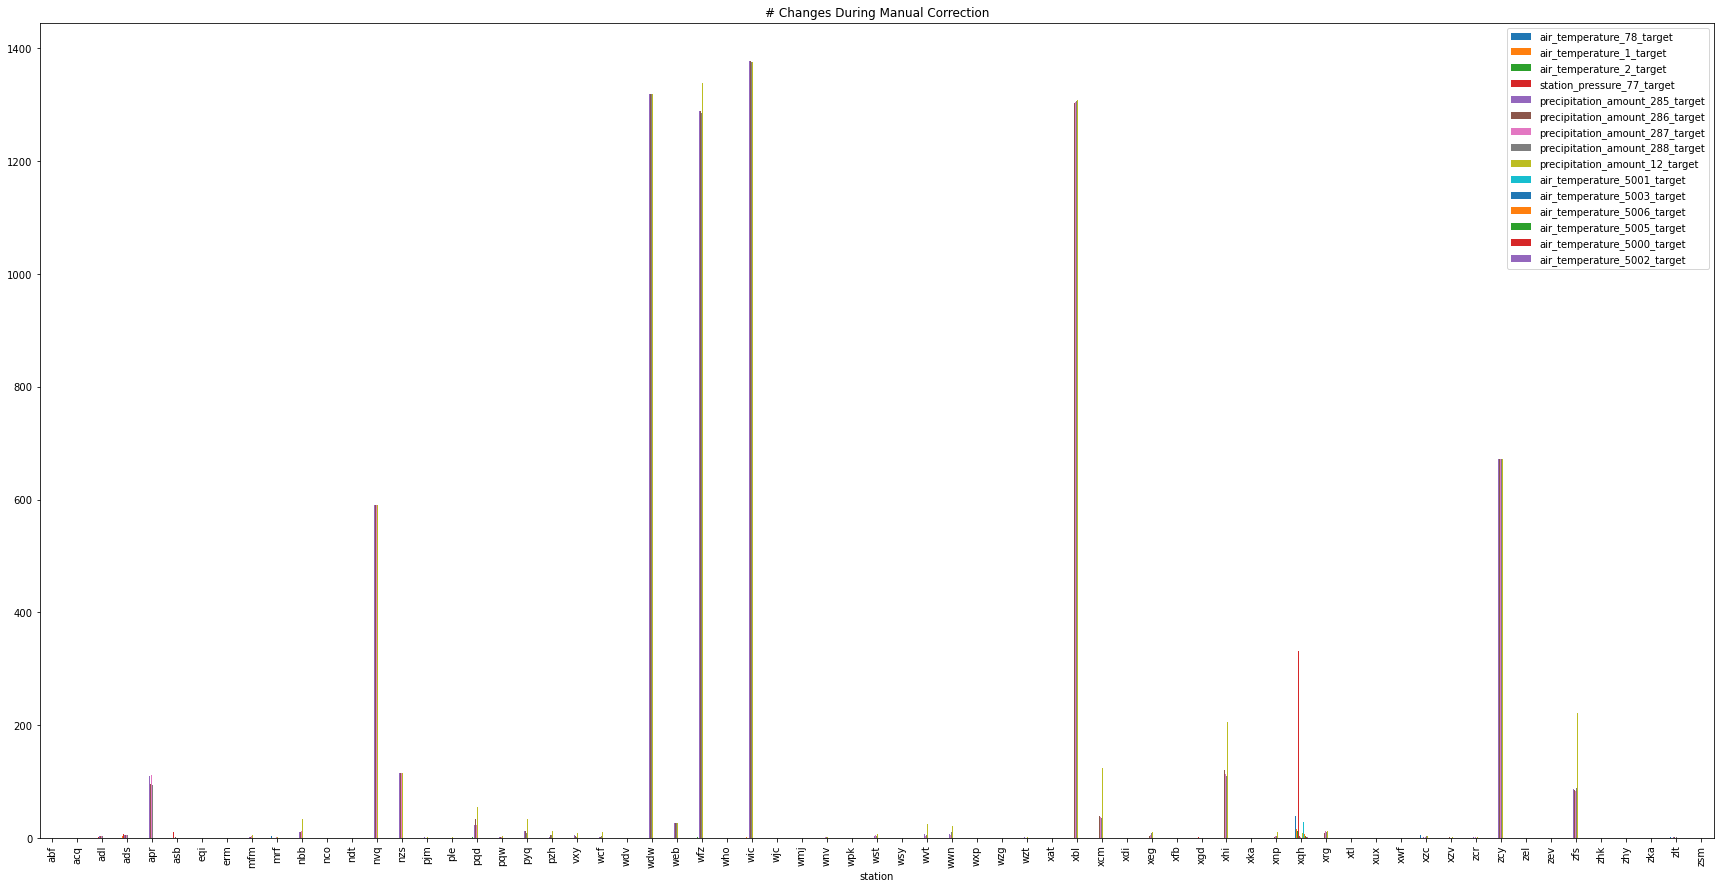

In [56]:
df_target_stats = target_stats(df_target)
df_target_stats.plot.bar(figsize=(30,15), title='# Changes During Manual Correction')
plt.show()

**Pressure** and **temperature** seem to basically never seem to trigger and corrections after the initial quality assessment. 

**Precipitation** corrections affect only 4 stations (MFJ, NGH, XCM, ZRP) and also in an overall limited capacity (200 changes per year over all stations).

Let's widen the scope to the if there are other suitable candidates:

<Figure size 432x288 with 0 Axes>

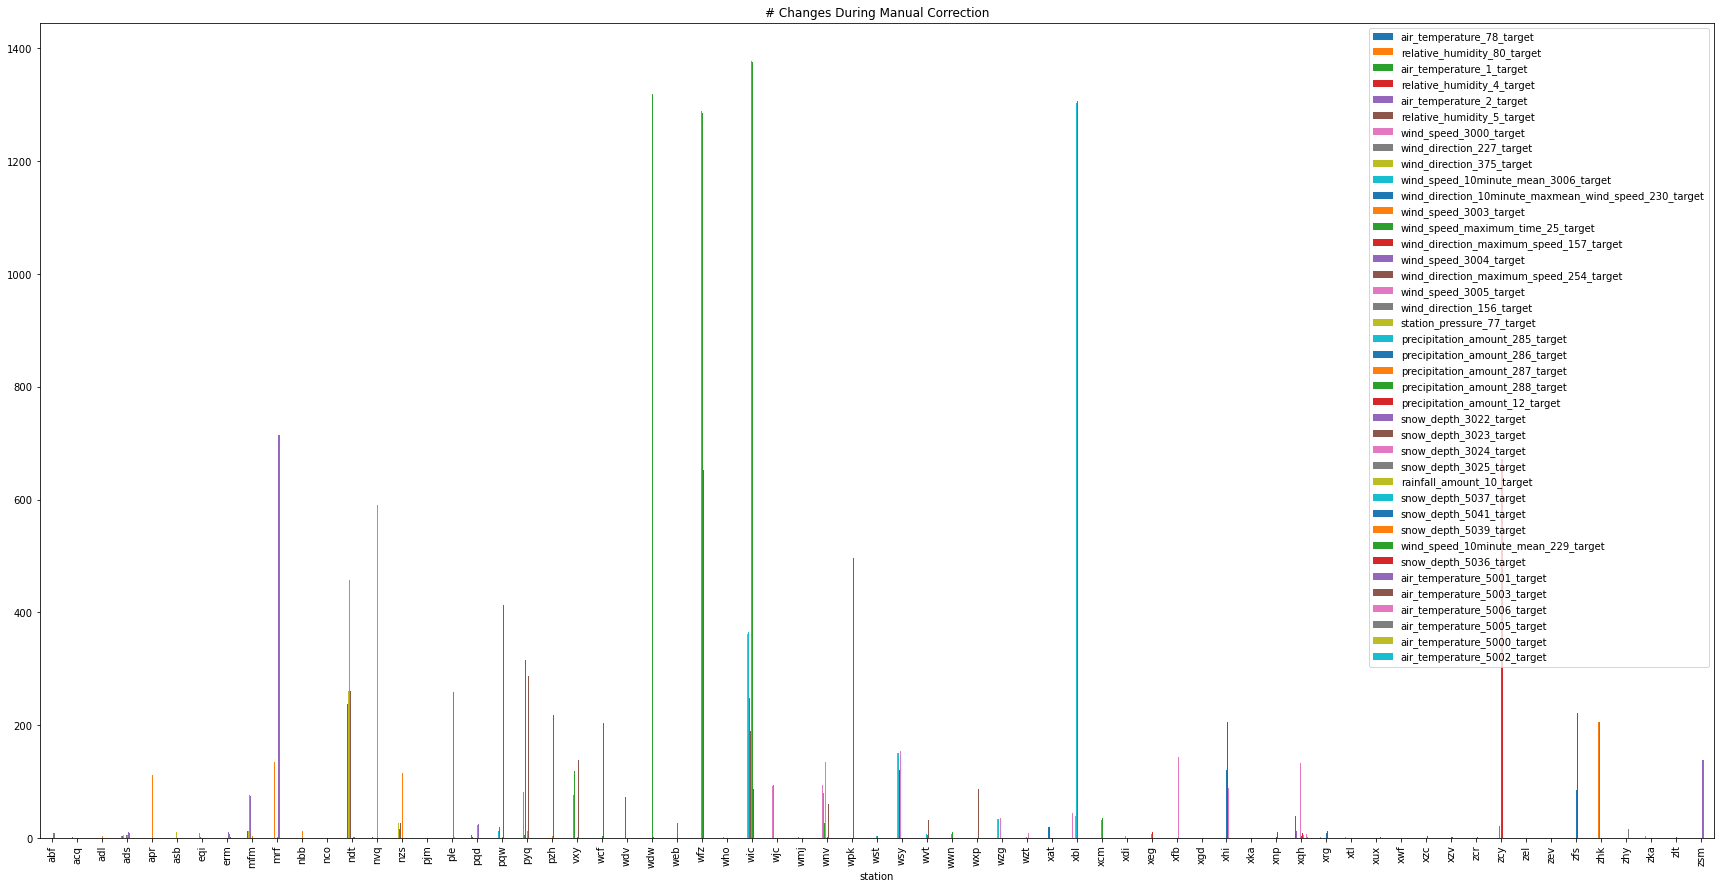

In [100]:
df_target_stats = target_stats(df_target, substrings=None)
df_target_stats.plot.bar(figsize=(30,15), title='# Changes During Manual Correction', color=plt.viridis())
plt.show()

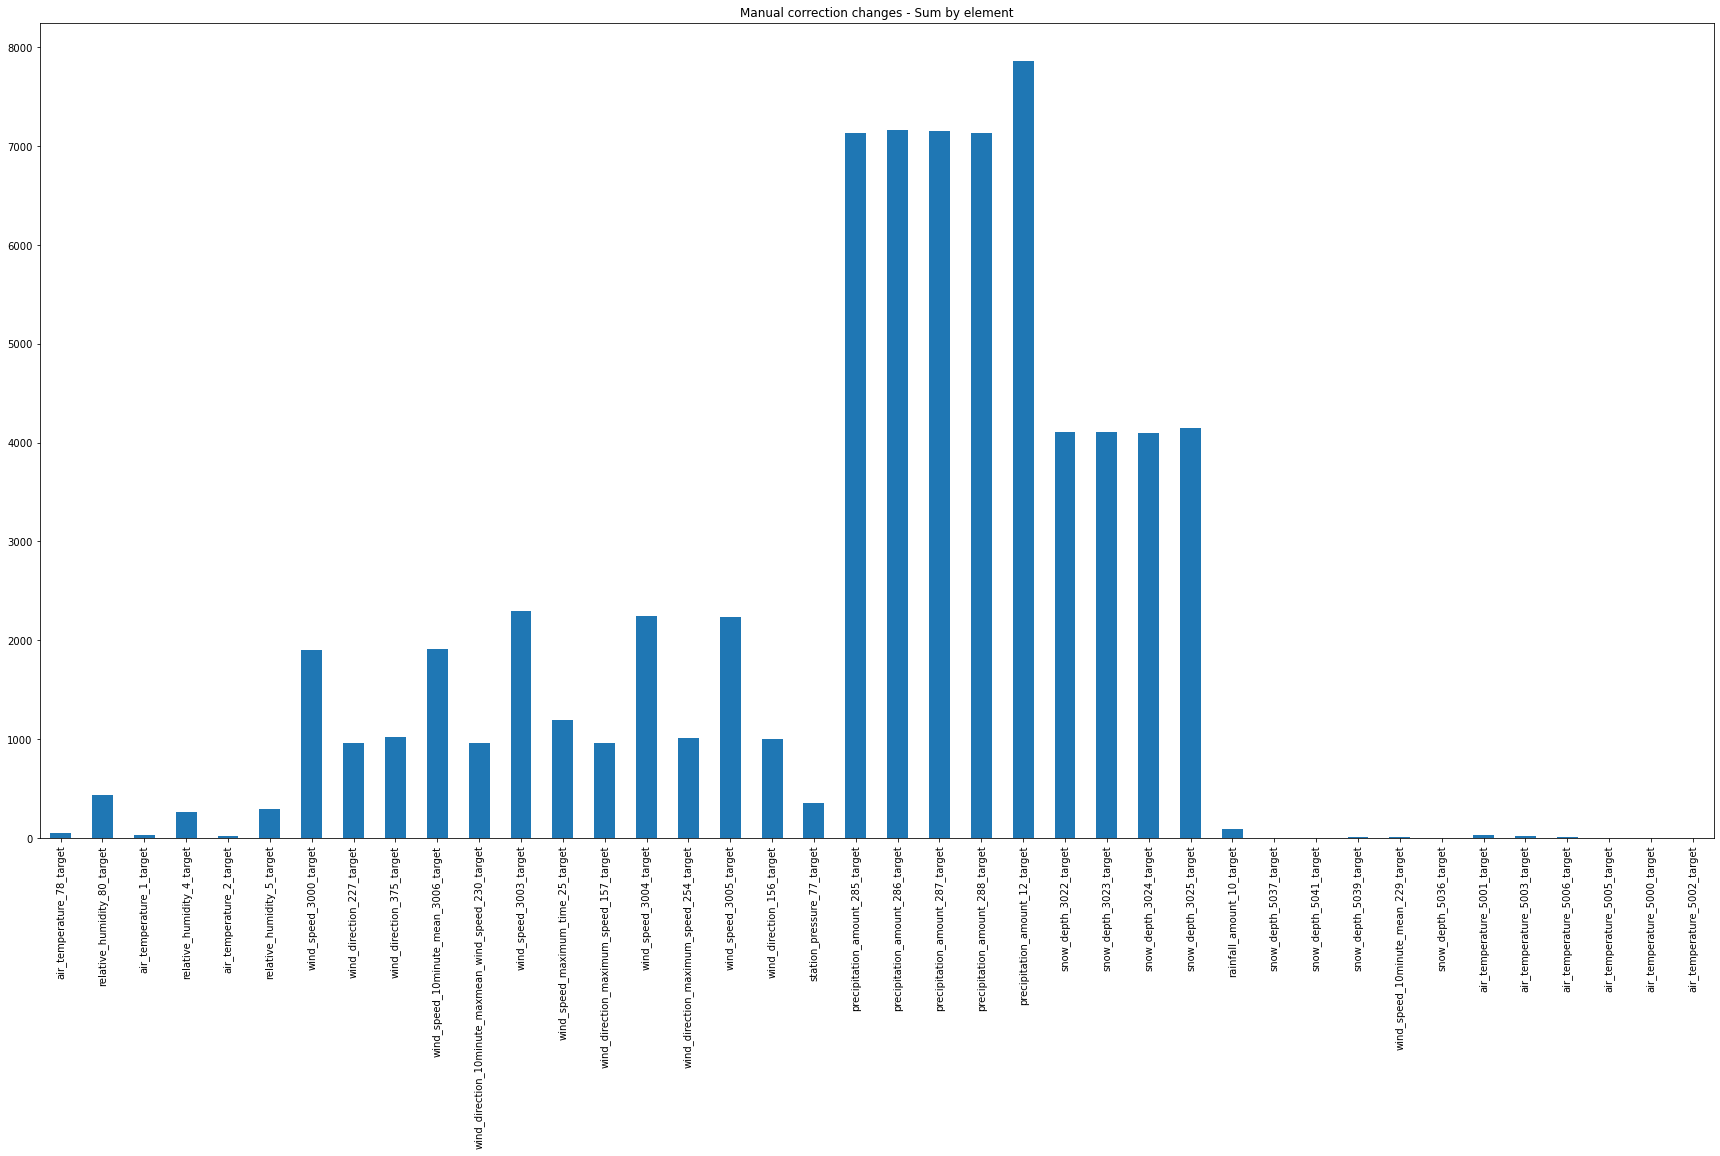

In [133]:
test = df_target_stats.reset_index()
test = test.drop("station", axis=1)
k = test.sum()
k.plot.bar(figsize=(30,15), title='Manual correction changes - Sum by element')
plt.show()

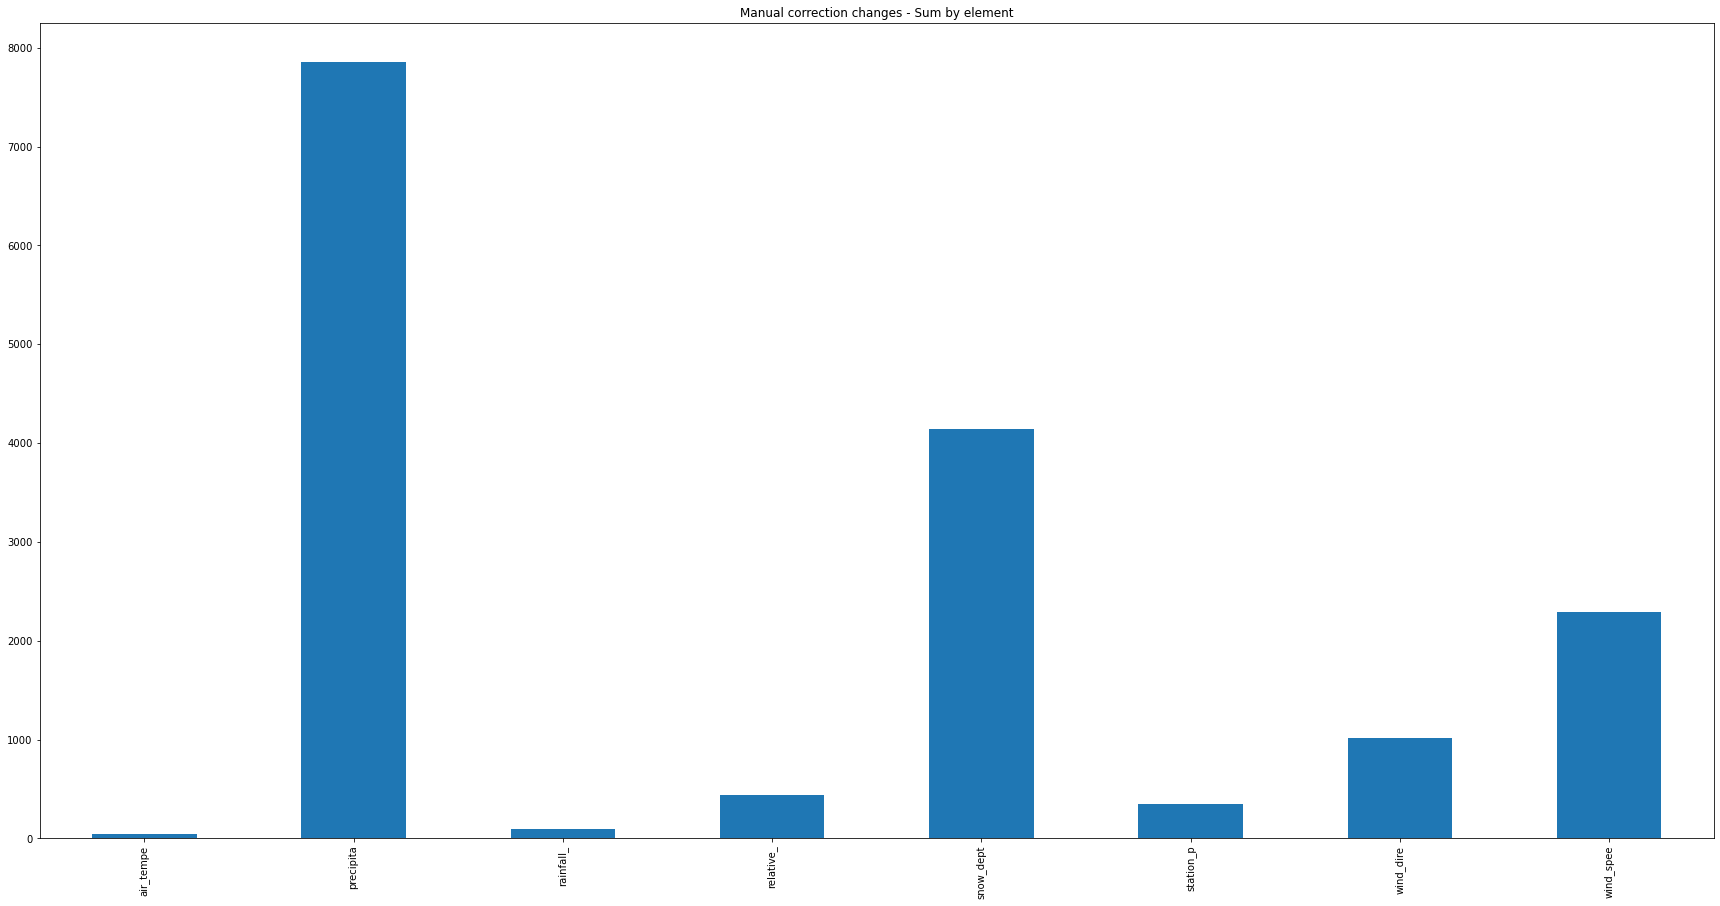

In [163]:
k_re = k
k_re.index= k_re.index.str[0:11]
k_re = k_re.groupby(k_re.index).max()
k_re.plot.bar(figsize=(30,15), title='Manual correction changes - Sum by element')
plt.show()


There seem to be some more issues related to wind (at WIC) and a more constant but small problem with snow depth at several stations.

Still not a clear candidate wherefore we should look into in which direction these corrections go.

## False Positives

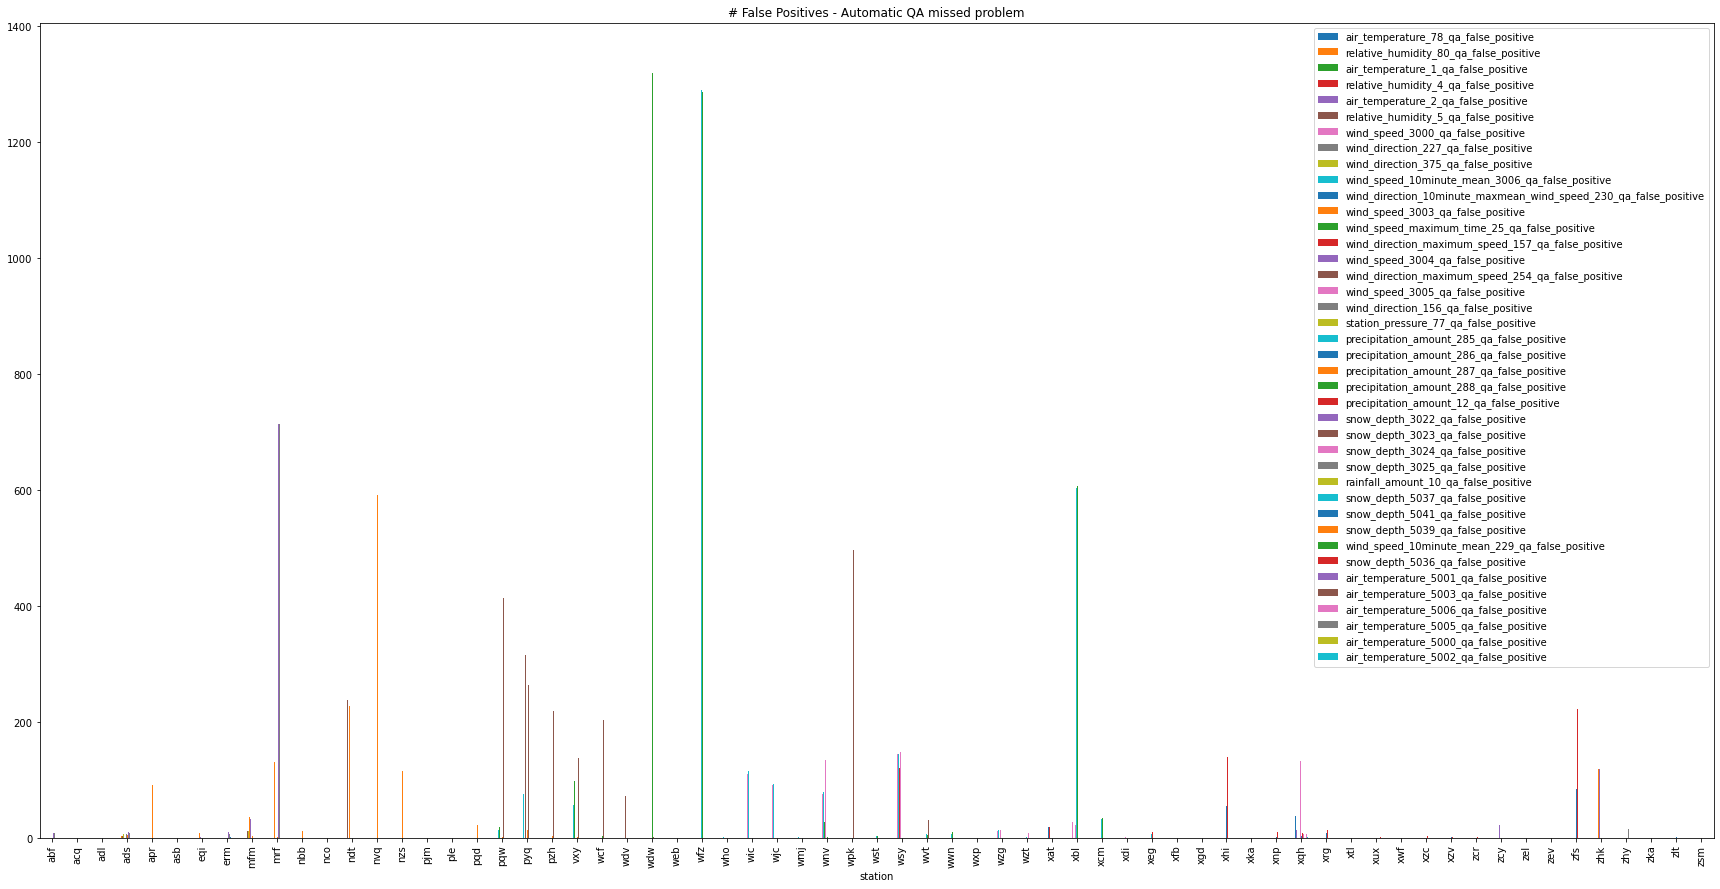

In [164]:
df_target_stats = target_stats(df_false_positive, target_suffix='qa_false_positive',substrings=[] )
df_target_stats.plot.bar(figsize=(30,15), title='# False Positives - Automatic QA missed problem')
plt.show()

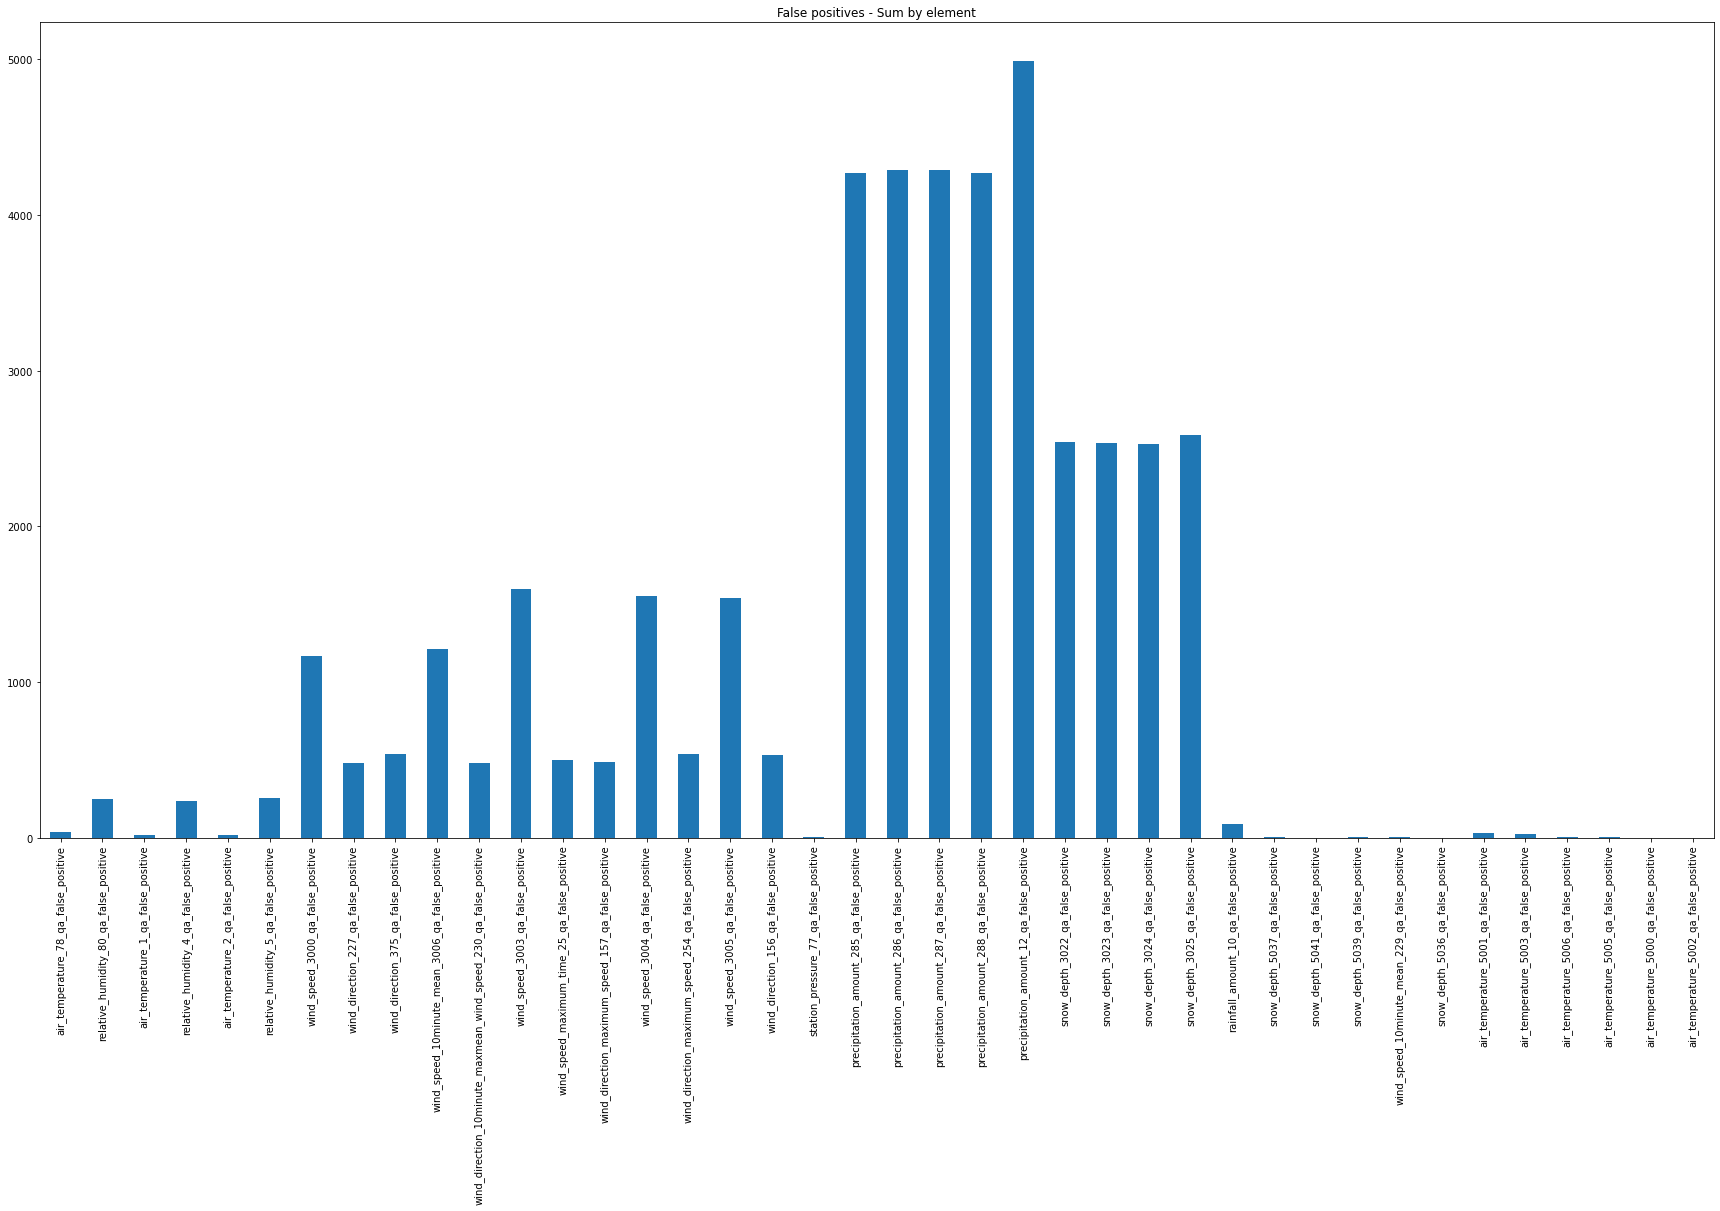

In [165]:
test = df_target_stats.reset_index()
test = test.drop("station", axis=1)
k = test.sum()
k.plot.bar(figsize=(30,15), title='False positives - Sum by element')
plt.show()

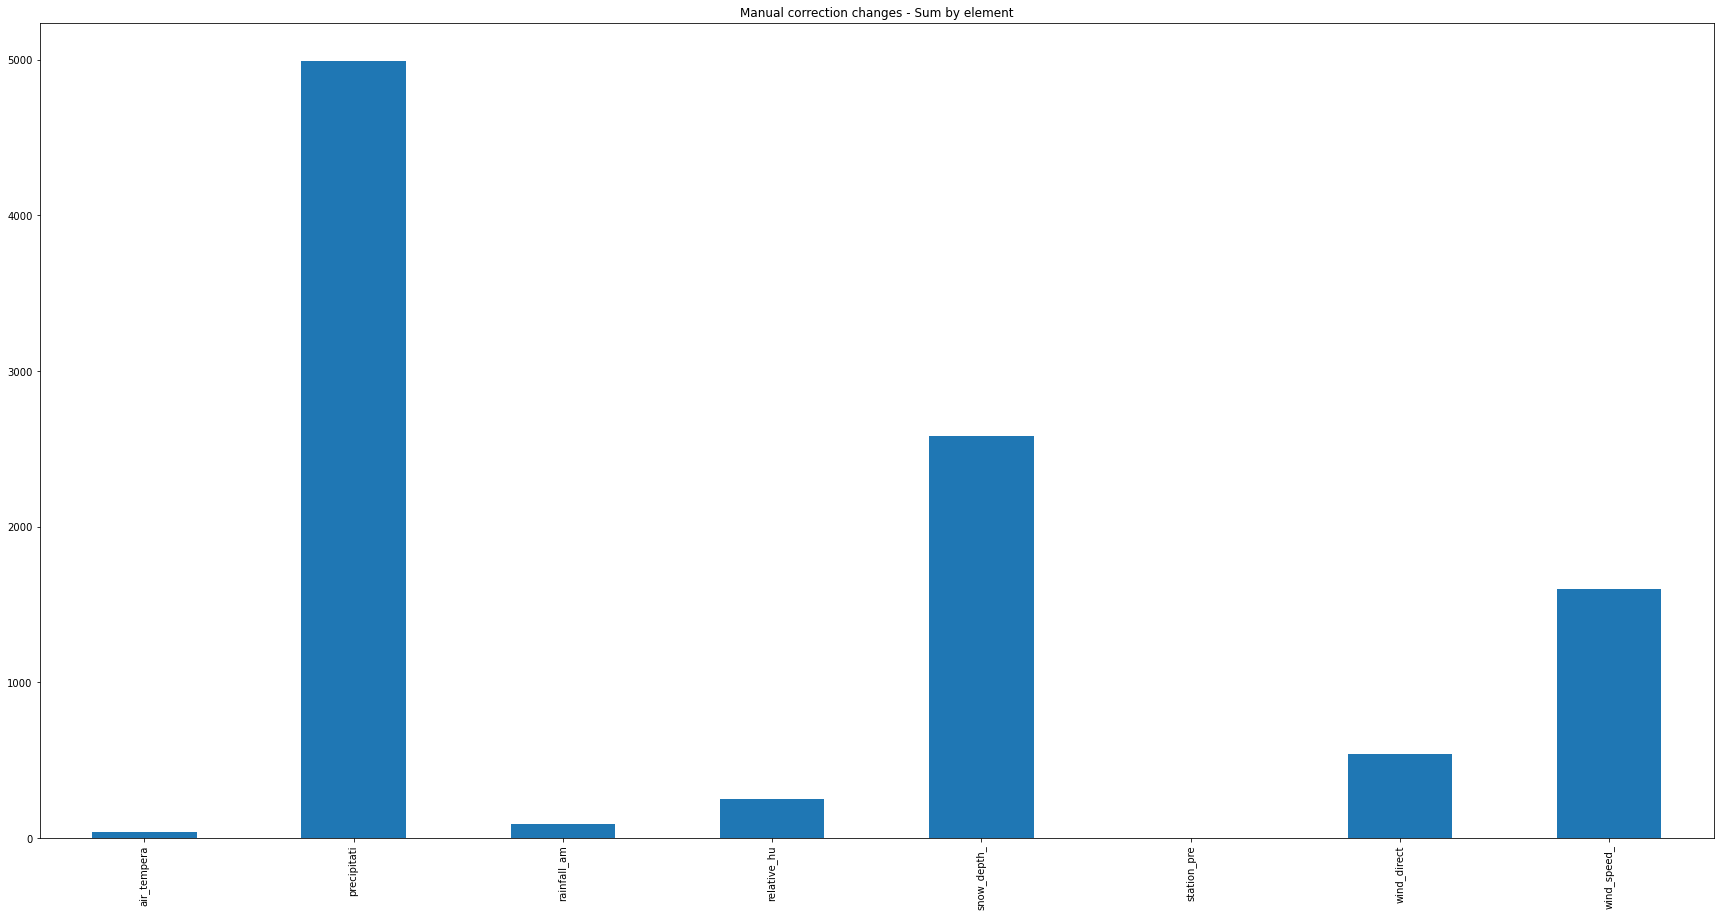

In [166]:
k_re = k
k_re.index= k_re.index.str[0:11]
k_re = k_re.groupby(k_re.index).max()
k_re.plot.bar(figsize=(30,15), title='Manual correction changes - Sum by element')
plt.show()


**False Positives** (problems which automatic QA missed to flag):

- 5 stations without any missed problems (RBI, NCO, NEK, WFZ, WKD)
- 1 station with basically only wind related problems (WIC)
- 3 stations with only precipitation related problems (MFJ, XCM, ZRP)
- 1 station with precipitation and wind certain (225,229,224,76) wind related problems (NGH)

Therefore __precipitation_amount_12__ would be a candidate for a model to improve the capture of all relevant issues as the problems occur in several (4) stations and with 200 samples overall (even thought not necessarly independent examples)

## False Negatives

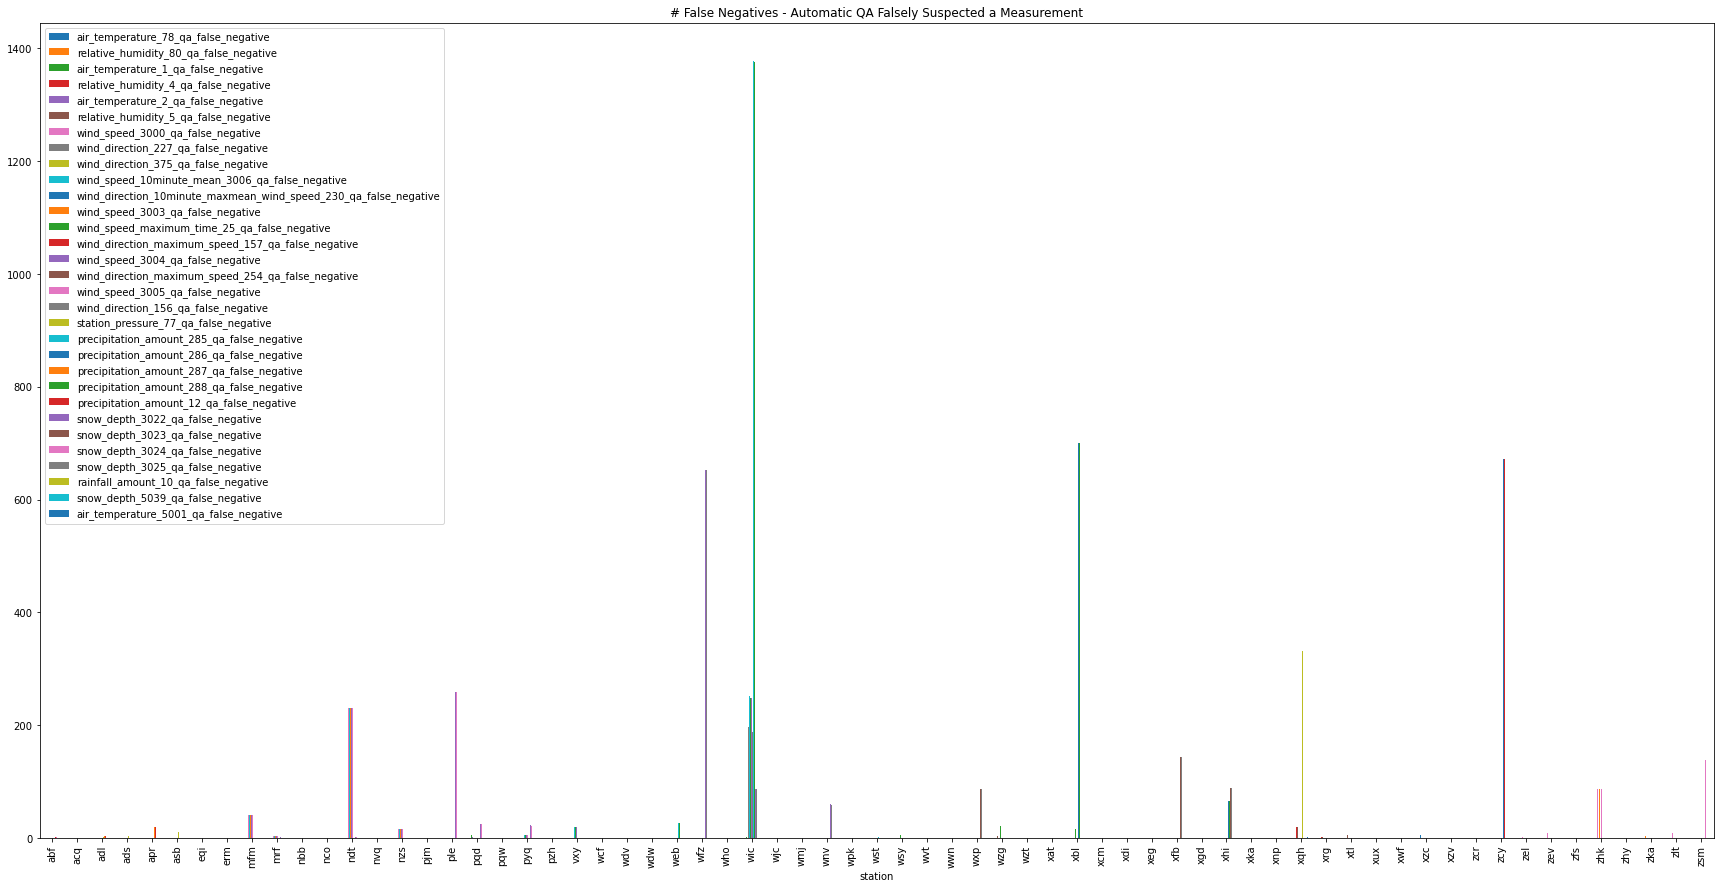

In [167]:
df_target_stats = target_stats(df_false_negative, target_suffix='qa_false_negative',substrings=[] )
df_target_stats.plot.bar(figsize=(30,15), title='# False Negatives - Automatic QA Falsely Suspected a Measurement')
plt.show()

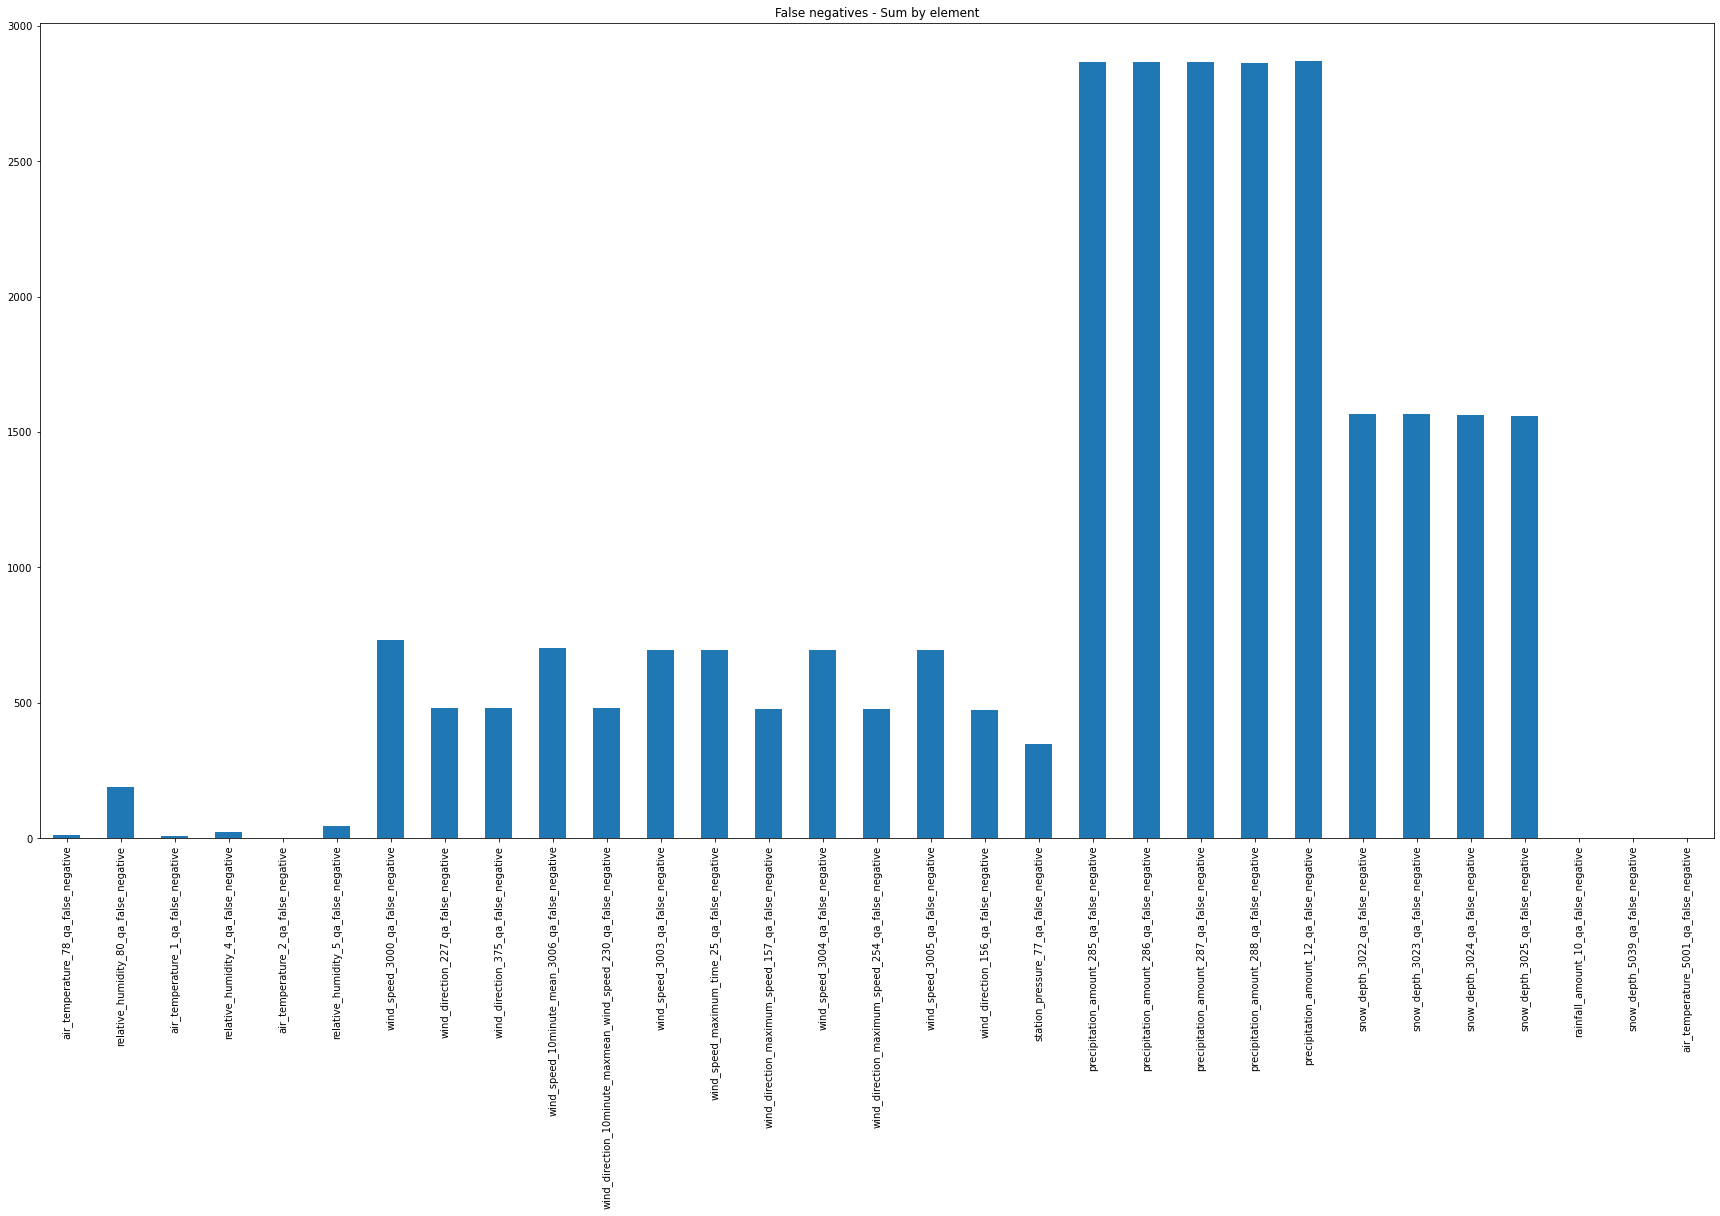

In [168]:
test = df_target_stats.reset_index()
test = test.drop("station", axis=1)
k = test.sum()
k.plot.bar(figsize=(30,15), title='False negatives - Sum by element')
plt.show()

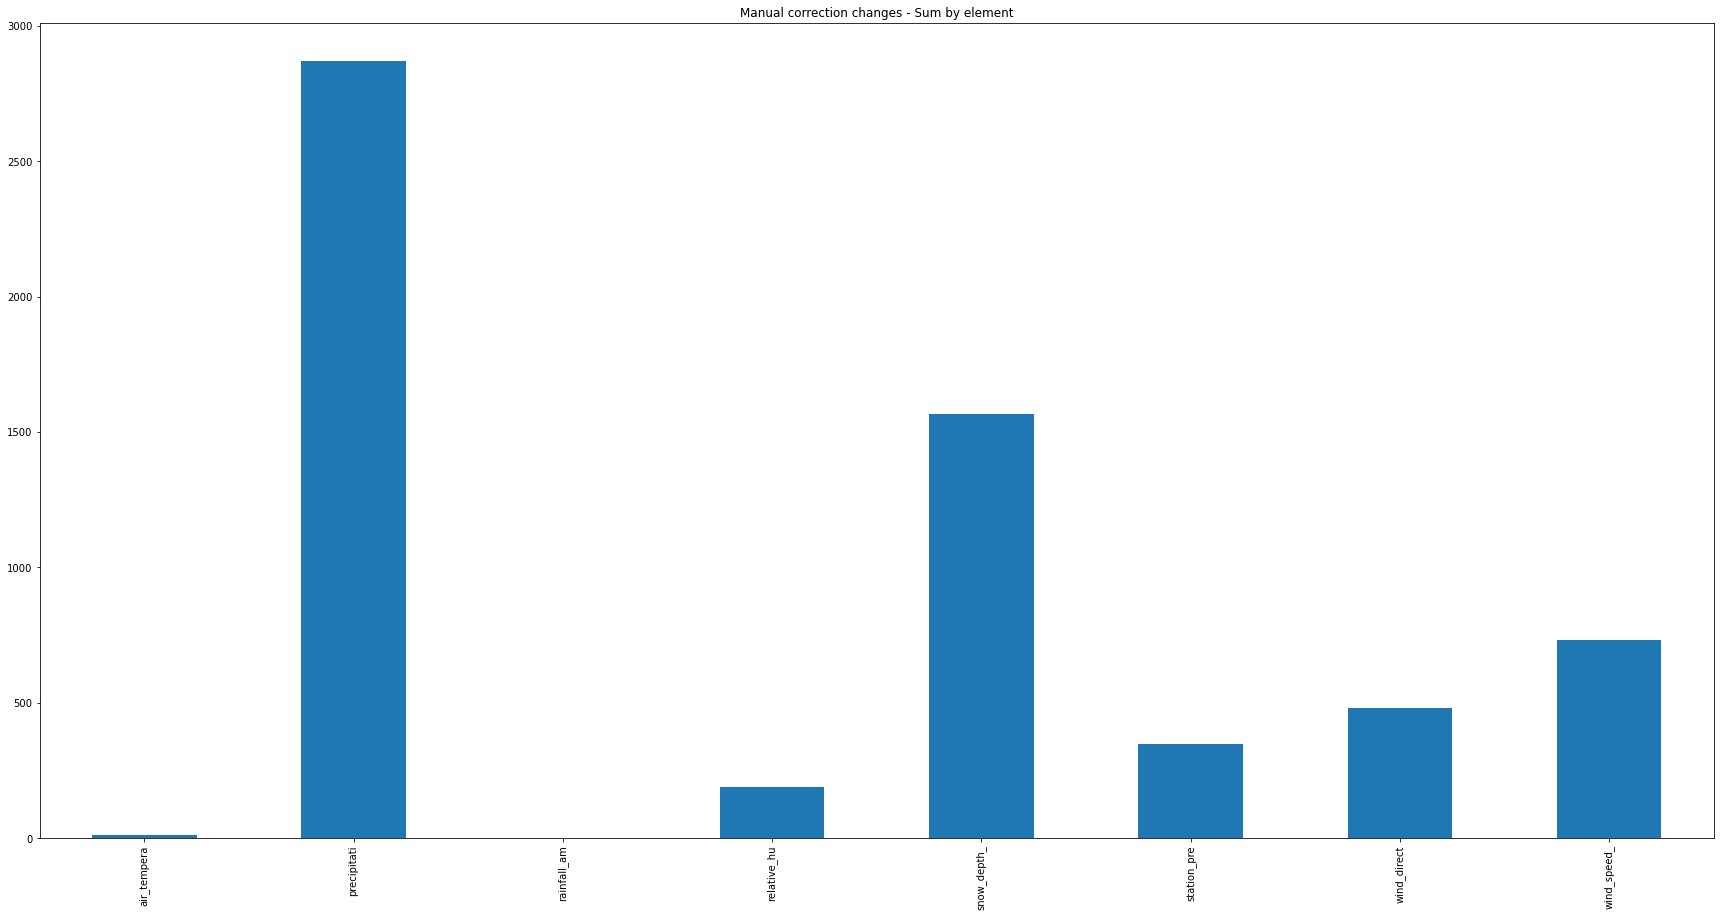

In [169]:
k_re = k
k_re.index= k_re.index.str[0:11]
k_re = k_re.groupby(k_re.index).max()
k_re.plot.bar(figsize=(30,15), title='Manual correction changes - Sum by element')
plt.show()


**False Negatives** (Automatic QA falsly qualified these measurments as correct):

- 3 stations without any falsely suspected measures (MFJ, WKD, XCM) 
- 6 stations with only snow depth related wrong suspicions (RBI, NCO, NEK, ZHK, ZRP)
- 2 stations with wind related wrong suspicions (NGH, WIC)

## Incidents

As mentioned at the end of "Data Driven: Variable Selection" looking at the pure number of corrections might be misleading in cases were there is actually only one underlying incident which causes a row of consecutive values to be changed and lets the problem appear greater on an individual view but doesn't represent a lot of different issues.

In [60]:
def changes_to_incidents(df_target, variable, station):
    base_cols = ['station_time_identifier',  '_merge', 'origin_filename', 'origin_filename_post_mc', 'time']
    df_prep_errors = df_slice_by_string_in_column(df_target, substrings=[variable], base_cols = base_cols)
    df_prep_errors = df_prep_errors[(df_prep_errors.station_time_identifier.str.startswith(station))].sort_values(by='time')
    df_prep_errors = df_prep_errors[df_prep_errors[variable]==1]
    df_prep_errors['time']=pd.to_datetime(df_prep_errors['time'])
    df_prep_errors.sort_values('time', inplace=True)
    df_prep_errors['time_diff'] = df_prep_errors.time.diff().dt.total_seconds().fillna(0)
    df_prep_errors = df_prep_errors.loc[df_prep_errors['time_diff']>3600]
    return df_prep_errors[variable].sum()

In [61]:
def convert_to_incident_stats(df_target_stats, df_target):
    df_target_incidents_stats = df_target_stats.copy()
    for variable in df_target_stats.columns:
        for station in df_target_stats.index:
            df_target_incidents_stats.loc[station,variable]=changes_to_incidents(df_target, variable, station)
    return df_target_incidents_stats

In [62]:
df_test = changes_to_incidents(df_target, variable='precipitation_amount_12_target', station='ngh')

In [63]:
pd.set_option('display.max_rows', None)
#df_prep_errors

In [64]:
df_target_stats = target_stats(df_target, target_suffix='target',substrings=[] )
df_target_stats = convert_to_incident_stats(df_target_stats, df_target)

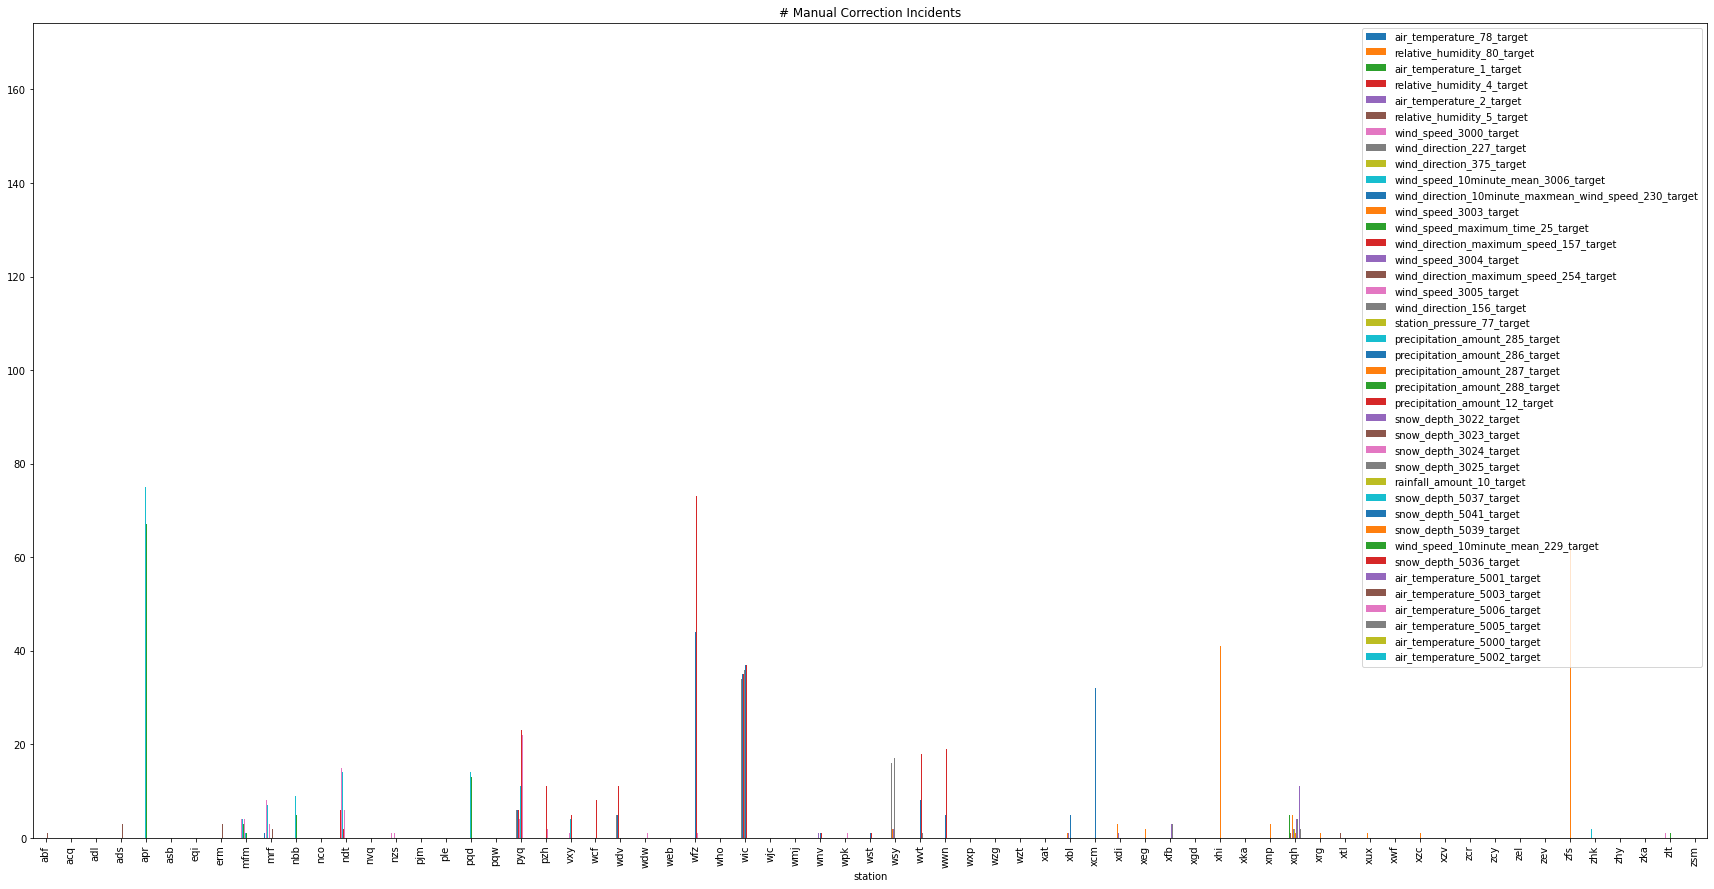

In [65]:
df_target_stats.plot.bar(figsize=(30,15), title='# Manual Correction Incidents')
plt.show()

In [66]:
df_FN_stats = target_stats(df_false_negative, target_suffix='qa_false_negative',substrings=[] )
df_FN_incident_stats = convert_to_incident_stats(df_FN_stats, df_false_negative)

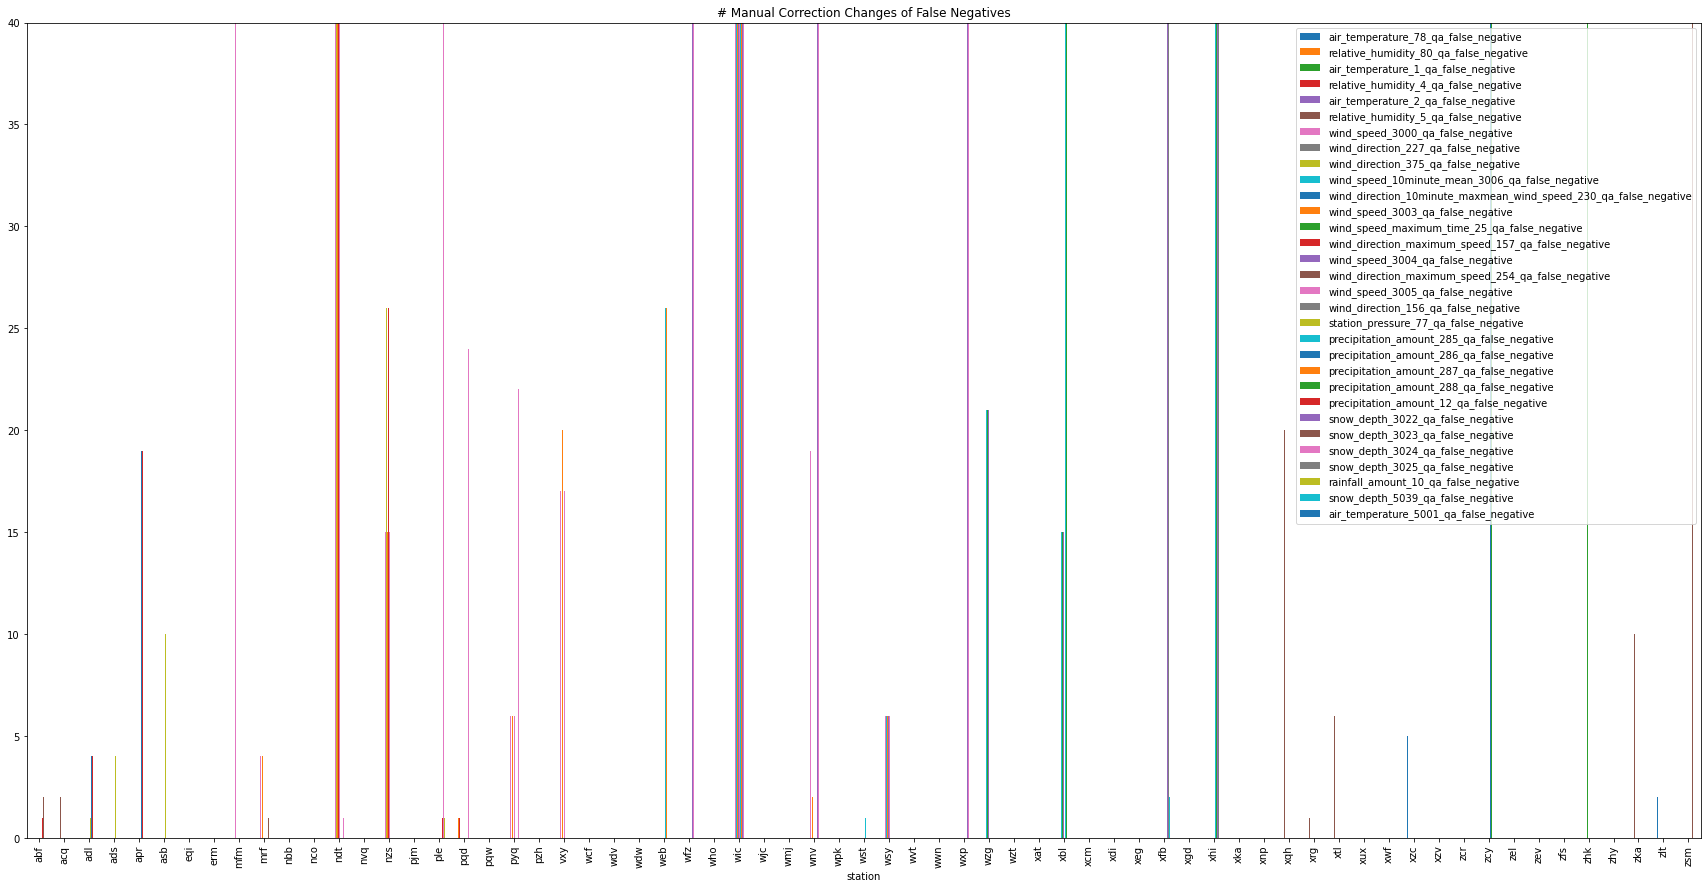

In [67]:
df_FN_stats.plot.bar(figsize=(30,15), title='# Manual Correction Changes of False Negatives', ylim=(0,40))
plt.show()

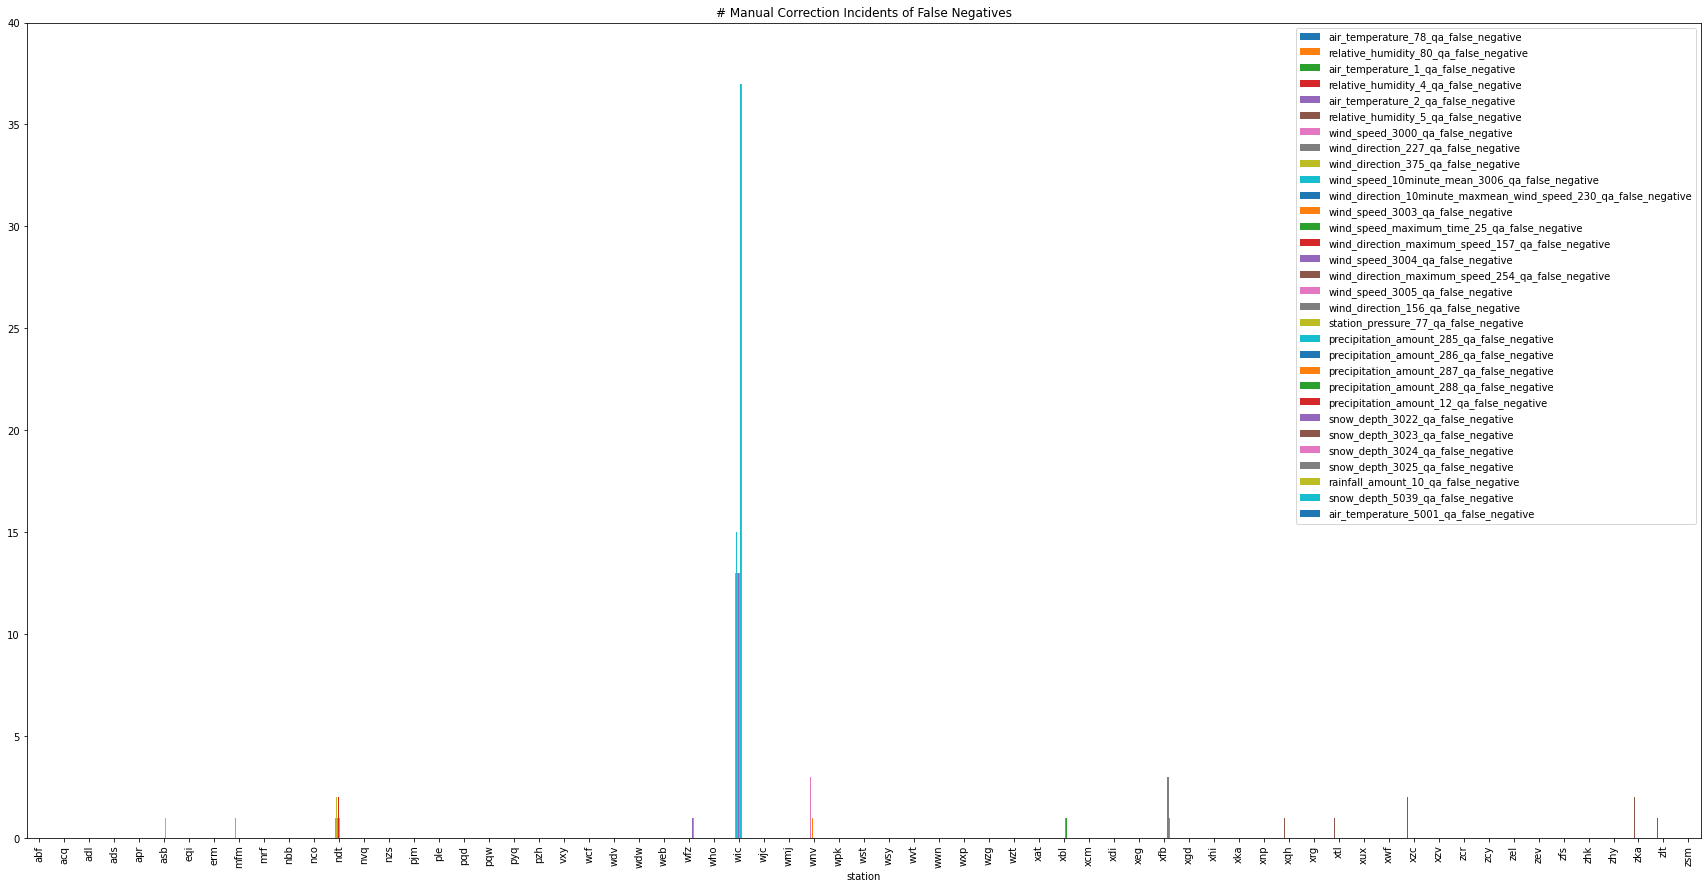

In [68]:
df_FN_incident_stats.plot.bar(figsize=(30,15), title='# Manual Correction Incidents of False Negatives', ylim=(0,40))
plt.show()

In [69]:
for sd_var in ['3022', '3023', '3024', '3025']:
    print(df_test[df_test['snow_depth_'+ sd_var +'_qa_false_negative']==True]['snow_depth_'+sd_var+'_overall_qa_summary'].value_counts())

IndexError: invalid index to scalar variable.

Seems like all the issues with snow depth are related to the provider/station sending a "surpress" flag and this flag than being overturned. 

In [70]:
df_test['snow_depth_3022_overall_qa_summary'].value_counts()

IndexError: invalid index to scalar variable.

Those numbers are only restricted to files were actually something was changed for any variable (can be unrelated to snow depth). The true number of QA results will be very different.

# QC Remarks

In [ ]:
def get_qc_remarks_info(df_result):
    df_remarks = df_slice_by_string_in_column(df_result, substrings=["qc_remark"], base_cols = base_cols)
    cols = df_remarks.columns
    cols = cols[2:]
    remarks = pd.DataFrame()

    for col in cols:
        df_temp = pd.DataFrame(df_remarks[col].value_counts())
        df_temp['var'] = df_temp.columns[0]
        df_temp.columns = ['count', 'var']
        if len(remarks)==0:
            remarks = df_temp
        else:
            remarks = pd.concat([remarks,df_temp])
    return remarks

remarks = get_qc_remarks_info(df_result)

In [ ]:
remarks[remarks['count']>5].sort_values(by='count', ascending=False)